In [1]:
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as ss
import os
import math

## Table of Content
1. Sequencing quality control
2. PrimerID and barcode calling
3. Barcode diversity and other analysis

### 1. Read depth and PrimerID read count distribution

In this section, I will do quality control batch by batch. Each batch is an individual sequencing run. We will primarily look at the sequencing depth of each sample and how many read does each PrimerID has. This roughly tells us if each sample is sequenced sufficiently.

In brief, we will process the data in following way:
1. call barcode and primerID on server.
2. count the read frequency of PrimerID. Set a read frequency cutoff to call true PrimerIDs.
3. call the barcode that is linked to the true PrimerID.
4. count the frequency of barcodes. The barcode is quantified by the number of unique primerIDs.

Before diving in the pipeline, we look at the qualities of our sample.

### batch1
JCK8, CEM

In [6]:
infiles = sorted(glob.glob('barcode/batch1/*.txt'))
s1list = [x.rsplit('HiSeq_R1_')[-1].rsplit('.')[0] for x in infiles]

In [7]:
depthdict = {}
for sample in s1list:
    inhandle = open('barcode/batch1/HiSeq_R1_'+sample+'.txt')
    depth = 0
    for line in inhandle:
        depth += 1
    inhandle.close()
    depthdict[sample] = depth

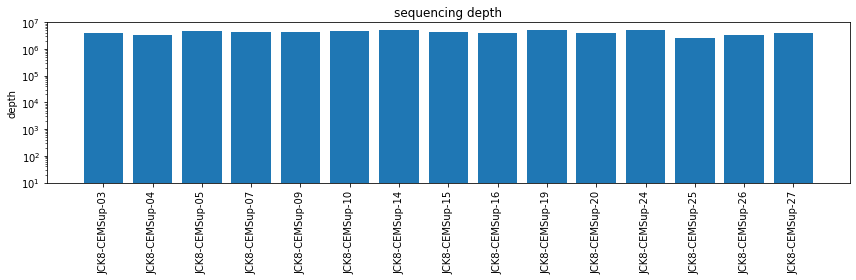

In [9]:
plt.figure(figsize=(12,4))
depthlist = list(depthdict.values())
plt.bar(s1list,depthlist)
plt.yscale('log')
plt.title('sequencing depth')
plt.xticks(rotation=90)
plt.ylabel('depth')
plt.ylim([1e1,1e7])
plt.tight_layout()
plt.savefig('sequencing_depth_batch1.png',dpi=600)

Every sample has more than 1 million informative reads. This should be sufficient in most cases.  

However, the proper sequencing depth should be determined by how much RNA molecules are subject to sequencing protocol.
In our pipeline, the sequencing depth should be determined by the number of cDNA molecules used as PCR templates. This number could be calculated from qPCR, or back-calculated from our sequencing result.

Ideally, a 5 fold coverage of each cDNA molecule template should be sufficient to accurately call primerID or barcode. 
Sequencing too deep not only cost more, but introduce unnecessary errors.

In [57]:
piddict = {}
for sample in s1list:
    piddict[sample] = {}
    inhandle = open('barcode/batch1/HiSeq_R1_'+sample+'.txt')
    for line in inhandle:
        line = line.rstrip().rsplit('\t')
        pid  = line[1]
        if pid not in piddict[sample]:
            piddict[sample][pid] = 0
        piddict[sample][pid] += 1
    inhandle.close()

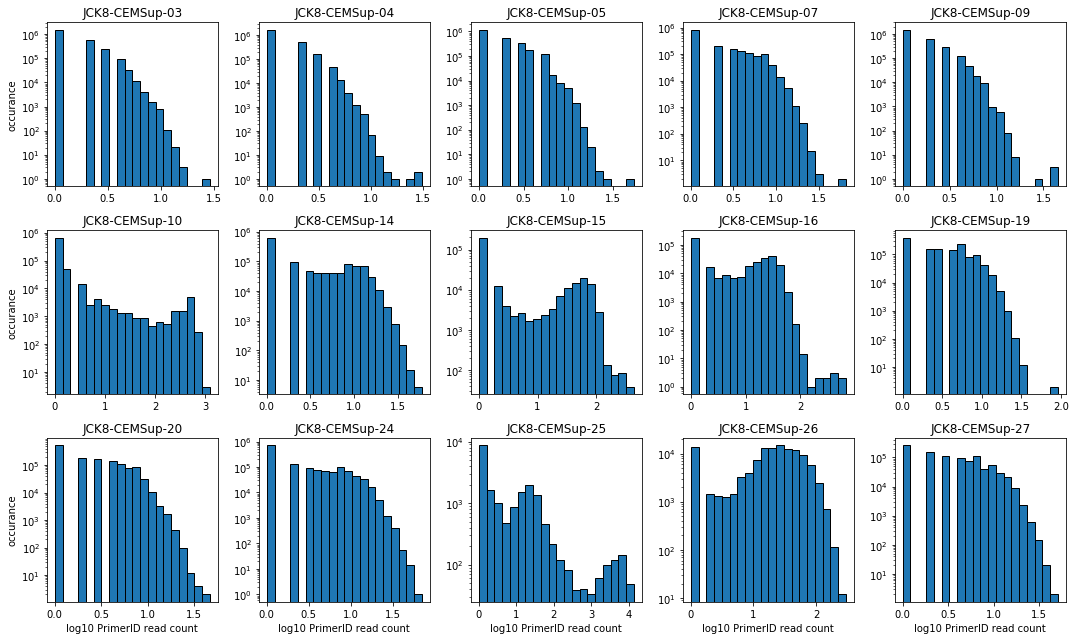

In [59]:
plt.figure(figsize=(15,9))
ploti = 0
thredict = {}
for sample in s1list:
    ploti += 1
    plt.subplot(3,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(piddict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 11: plt.xlabel('log10 PrimerID read count')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch1.png',dpi=600)

The distribution of primerIDs follow a bimodal distribution. It is particularly clear in samples like CEM10, CEM15. However, there is only one peak (or half peak) for sample CEM03 or CEM20. This indicates the sequencing depth may not be high enough to cover all PrimerIDs. Let's look into the primerID sequences to confirm that.

In [64]:
sample = 'JCK8-CEMSup-10'
toplist = sorted(piddict[sample].items(), key=lambda kv:-kv[1])
for i in range(30):
    print(toplist[i])

('ATAGTAGTGGCGT', 1252)
('GGCGCCATTATGT', 997)
('TCCCAACTACCAT', 885)
('TCGGTCAGCAAGT', 856)
('TGAGTAGCTGGGT', 847)
('TGGAGTGTCCGGT', 804)
('TCGTTATTCAGGT', 786)
('TATTCAGTGGGAT', 784)
('TTCATGCGTGGGT', 782)
('TCGCTCATCACTT', 779)
('CGGCGAACTGGGT', 778)
('CGGACTAACTTGT', 778)
('CGTCGAGTCAGTT', 770)
('TTTGGGGCAGGGT', 768)
('TAGCGGTGGGGAT', 764)
('TGCTGATGACAGT', 750)
('TTCGAATAGCTGT', 748)
('TACGTACTGCCGT', 744)
('TCGTTGTTTCCGT', 739)
('TGCCTATGCCGAT', 737)
('TCCTGCACATTGT', 727)
('TCTTAGTGTCGTT', 717)
('GGGCTGGTGTGAT', 716)
('TTATCGACTGTCT', 710)
('ATTTCCGGTGGGT', 707)
('TGCCAAGGGAAGT', 704)
('GACGGATGCGTGT', 702)
('ATCCGAGGTTGTT', 702)
('TGTGACAGCTCCT', 701)
('CGGTAAGGATCGT', 700)


The top30 most abundant PrimerIDs in sample CEM10 distributed quite uniformly. The sequences are unique and different.  This inidcates they are from distinct cDNA molecules. The materials for the PrimerID protocol have high copy number and good quality. 

This sample has 4.88 million reads. PrimerID has an average of 6.49 read count.  
If we set a threshold of 100 read count for valid PrimerIDs (telling from the above histogram), we will get ~10,000 PrimerIDs. This indicates ~10,000 cDNA molecules were used as the material for the PrimerID protocol.   
Let's remember these numbers since they are key parameters to generate a high quality sequencing result.

In [77]:
sample = 'JCK8-CEMSup-15'
depth = sum(list(piddict[sample].values()))
readlist = list(piddict[sample].values())
totalpid = len(readlist)
goodpid = len([x for x in readlist if x >10])
print('Sample '+sample+' has '+str(depth)+' reads.\nPrimerIDs have an average of '+str(float(depth)/float(totalpid))+' reads. There are around '+str(goodpid)+' valid PrimerIDs.')

Sample JCK8-CEMSup-15 has 4275383 reads.
PrimerIDs have an average of 14.359595884958873 reads. There are around 75977 valid PrimerIDs.


Because of the existance of PCR skewing (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4666380/), it is not possible to set an absolute cut-off and categorize true PrimerID without uncertainty. I tend to be conservative at setting the initial cutoff on PrimerID read frequency, including more primerIDs for downstream analysis, and use other data filtering method for barcodes for accurate barcode calling and quantification.

In [62]:
sample = 'JCK8-CEMSup-03'
toplist = sorted(piddict[sample].items(), key=lambda kv:-kv[1])
for i in range(30):
    print(toplist[i])

('CTTGTTCCACCTGT', 29)
('CTTGTTCCACCT', 16)
('CTTAATTTGGTTT', 16)
('TATGATCGTGGGT', 15)
('TGTAAGCGTGGGT', 14)
('ATTTGCGTGTGGT', 14)
('AGGGTCAGTGGGT', 14)
('TTTGGTGTATGTT', 14)
('TTGAGTTGTGGGT', 14)
('TGCTTGTTTTAGT', 13)
('ATATCGTTAATTT', 13)
('ACTATGCGTGGGT', 13)
('AGTGCTTAGTGAT', 13)
('TTTTGATTGTTGT', 13)
('TATGTGGGGGAGT', 13)
('TAAGTTTTTTTAT', 13)
('AGTTGAGGTGGGT', 13)
('ATAGTTTTAGGGT', 13)
('TTTTTGTTCTTGT', 13)
('TAACTCAGTGTGT', 13)
('TGTGTTAGACTTT', 13)
('TATTGGCGTGGGT', 13)
('TGTATGTATGGGT', 13)
('TGCAAGGGTGGGT', 13)
('CTTAGTATAACTT', 13)
('TGTCGACAATTTT', 12)
('TATAGTAACATTT', 12)
('TAATTGTATCAGT', 12)
('TTTGTTCCATCTT', 12)
('TTTAGGTAGTGTT', 12)


Sample CEM03 did not get an ideal PrimerID distribution. It has ~4.02 million valid reads. But due to too many input cDNA molecules in the PrimerID protocols, each PrimerID is not sequenced deep enough. This creates some difficulties at setting the threshold to call valid PrimerIDs.  
There are 3 solutions for this problem:
1. Use less input cDNA molecules for PCR. This gives the best result.
2. Sequence current sample deeper. We need to scale up 10-100 times for this sample. This may not be realistic.
3. Set a small read count threshold. Call some confident PrimerIDs and corresponding barcodes. Do furthur data filtering in the next step.  

For now, I will do solution 3.

In [75]:
sample = 'JCK8-CEMSup-16'
toplist = sorted(piddict[sample].items(), key=lambda kv:-kv[1])
for i in range(30):
    print(toplist[i])

('TGCTGAACTGGT', 671)
('TGCGCAGTGCTCT', 565)
('CTTGGGCCAATAT', 439)
('GGGATAAGTCGGT', 400)
('TCGGGGTTTCATT', 354)
('CGTTATGTGGAAT', 299)
('GTTTCACCACTTT', 286)
('CTATACAGATACT', 245)
('CAGTGAATTTCTT', 188)
('ACCCATACATCGT', 145)
('TTTCGTGCGCGCT', 120)
('TCTGATGGTAGTT', 118)
('TGTGCCATGTTAT', 108)
('TCGTGCAGATGGT', 105)
('TGTGTTTGGTGTT', 103)
('TGTGCGAGTGGGT', 103)
('GCGTGGGTGACCT', 102)
('TGGAGCGAAGTAT', 99)
('TTAGTCGGTCAGT', 97)
('CGTGGTACGGCAT', 97)
('TGTGGTGTTGGAT', 96)
('TCTATGGCCCAAT', 96)
('GGTCATGATATTT', 96)
('TGTGTGTTGGTGT', 96)
('CGTGTCCGTACGT', 93)
('TGACGTGCGGCGT', 92)
('CATGACGATGCGT', 91)
('TTCCGTTGTGGGT', 91)
('TCAAGCGCCAAGT', 90)
('CGGACGTGTGGGT', 90)


The PrimerID distribution of CEM16 has multiple peaks. I am not sure why it's the case. The sequences for PrimerIDs look normal(no apparant child PrimerIDs). I will assume both peaks are valid PrimerIDs.

Following algorithm will classify PrimerID and label valid ones orange.

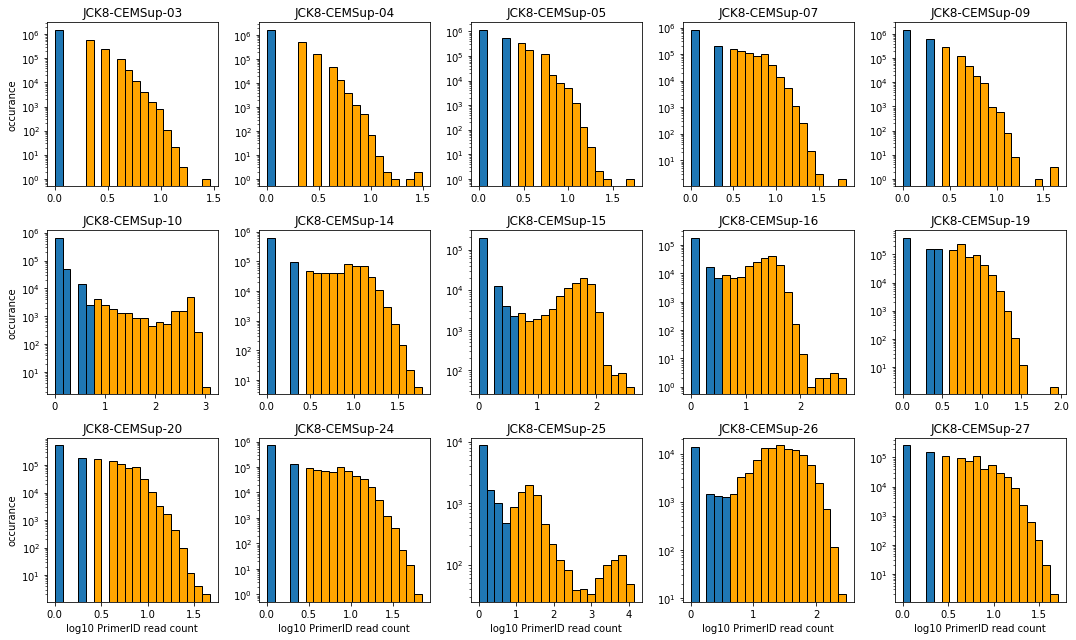

In [80]:
plt.figure(figsize=(15,9))
ploti = 0
t1dict = {}
for sample in s1list:
    ploti += 1
    plt.subplot(3,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(piddict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 11: plt.xlabel('log10 PrimerID read count')
    for i in range(3,19):
        if n[i+1] != 0 and n[i]/n[i+1] < 1 and n[i] >= 0:
            peaki = i
            break
    t1dict[sample] = (10**bins[peaki])
    for i in range(20):
        if bins[i] > np.log10(t1dict[sample]):
            patches[i].set_facecolor('orange')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch1.png',dpi=600)

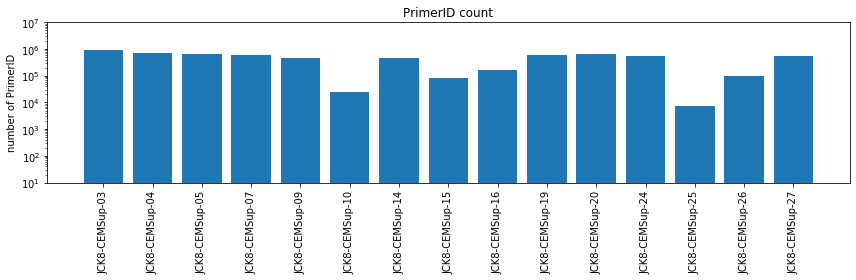

In [82]:
pidcountlist = []
for sample in s1list:
    countlist = list(piddict[sample].values())
    pidcount = len([x for x in countlist if x > t1dict[sample]])
    pidcountlist.append(pidcount)
plt.figure(figsize=(12,4))
plt.bar(s1list,pidcountlist)
plt.yscale('log')
plt.title('PrimerID count')
plt.xticks(rotation=90)
plt.ylabel('number of PrimerID')
plt.ylim([1e1,1e7])
plt.tight_layout()
plt.savefig('PrimerID_count_batch1.png',dpi=600)

Each sample 10,000 ~ 1,000,000 valid PrimerIDs. They will be used for downstream analysis.

**Re-sequencing suggestion:**  
Make library for CEM03, CEM04, CEM05, CEM07, CEM09, CEM20, CEM24, CEM27 with 10-fold less cDNA input, to increase PrimerID calling accuracy. However, this should not have much effect on barcode calling. Too much input is way less a concern than insufficient input.

### batch2 
JCK8 Bone marrow

In [83]:
reffile = open('barcode/tag_batch2.txt')
tagdict = {}
for line in reffile:
    line = line.rstrip().rsplit('\t')
    if 'BM-DNA' not in line[1]: continue
    tagdict[line[0]] = line[1]
reffile.close()
tagdict
#only need JCK-BM samples.

{'CACAGT': 'JCK-BM-DNA-03',
 'CGCGTC': 'JCK-BM-DNA-04',
 'TATCGC': 'JCK-BM-DNA-05',
 'TGTGCT': 'JCK-BM-DNA-09',
 'TCATGA': 'JCK-BM-DNA-14',
 'CGTAGC': 'JCK-BM-DNA-15',
 'CGATGT': 'JCK-BM-DNA-19',
 'AGTCAG': 'JCK-BM-DNA-20',
 'GCTGAC': 'JCK-BM-DNA-24',
 'ACGCGT': 'JCK-BM-DNA-27'}

In [84]:
infiles = sorted(glob.glob('barcode/batch2/Undetermined_S0_R1_001_*.txt'))
p2dict = {}
for tag in tagdict:
    p2dict[tagdict[tag]] = {}
for infile in infiles:
    inhandle = open(infile)
    for line in inhandle:
        line = line.rstrip().rsplit('\t')
        tag  = line[0]
        if tag not in tagdict: continue
        pid  = line[2]
        sample = tagdict[tag]
        if pid not in p2dict[sample]: p2dict[sample][pid] = 0
        p2dict[sample][pid] += 1
    inhandle.close()

In [85]:
s2list = list(p2dict.keys())
depthlist = [sum(p2dict[x].values()) for x in s2list]

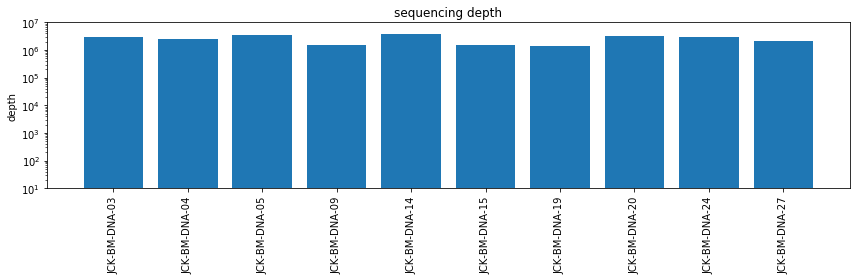

In [39]:
plt.figure(figsize=(12,4))
plt.bar(s2list,depthlist)
plt.yscale('log')
plt.title('sequencing depth')
plt.xticks(rotation=90)
plt.ylabel('depth')
plt.ylim([1e1,1e7])
plt.tight_layout()
plt.savefig('sequencing_depth_batch2.png',dpi=600)

More than 1 million for each sample. I am very satisfied with the sequencing depth.

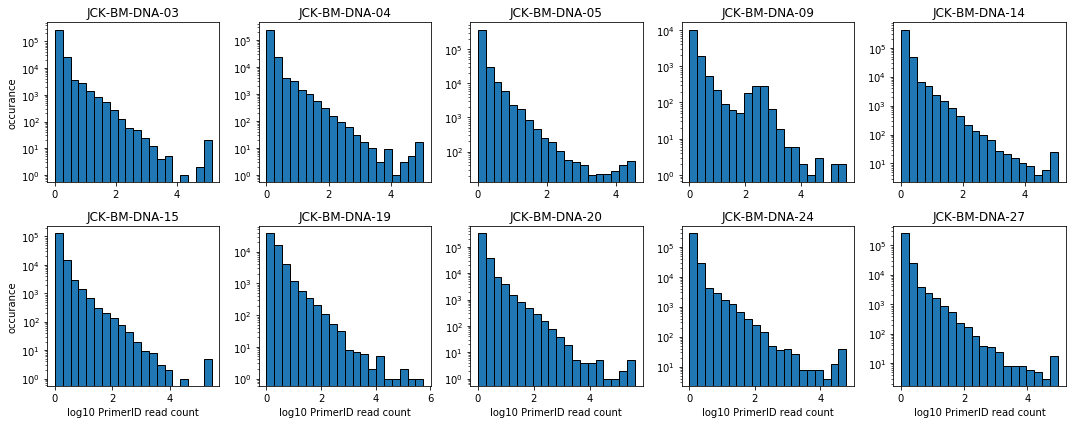

In [86]:
plt.figure(figsize=(15,6))
ploti = 0
thredict = {}
for sample in s2list:
    ploti += 1
    plt.subplot(2,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p2dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 6: plt.xlabel('log10 PrimerID read count')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch2.png',dpi=600)

The PrimerID distribution of bone marrow samples are very different from CEM samples. There is no bimodal distribution, but a simple Poisson distribution. Let's take BM03 as an example.

In [90]:
sample = 'JCK-BM-DNA-03'
toplist = sorted(p2dict[sample].items(), key=lambda kv:-kv[1])
for i in range(40):
    print(toplist[i])

('TGCTAGGTTGCAT', 142378)
('GTGAAGTGAAAAT', 137805)
('TTTTAAATGGTAT', 125185)
('TGCAGCTGAGCTT', 115718)
('TAGGTCCATAAAT', 114149)
('ACGGGGAGCCTCT', 111780)
('ATCCATGATATAT', 110612)
('TGTTTCGTGTCAT', 107456)
('GCCTACAGGATAT', 103956)
('TGCTTATCATTCT', 103561)
('TTAAGGTAGTTAT', 101103)
('GGTTGTGGTTATT', 99084)
('CGATGTAGTATCT', 98797)
('GCCCTAACTAATT', 97610)
('CTGAAAGACTGTT', 97564)
('CTAGACTTCGTGT', 95761)
('CTAATATGCGTGT', 94425)
('GCCAGCGTGGCGT', 89589)
('TCGCCTAAAGGGT', 83849)
('ATGTTCTAGTGTT', 80531)
('TAAATGTATCGTT', 70401)
('AAGAACTGAGTAT', 65954)
('CTGGAGTCAGTGT', 14608)
('AATGCCATTAAGT', 6839)
('CAAGTACCGGGTT', 6326)
('GATGCAAGTGATT', 6261)
('TCTTTAACGAAAT', 4120)
('AGGTGCAGCTAGT', 4066)
('TAATTGCGAACAT', 3515)
('TTTGATCCTGTTT', 3495)
('CCATGAATAGTAT', 3170)
('CGCTTTGGATTGT', 3115)
('CGATAGCGTTTCT', 1901)
('GAACAGCCTGCGT', 1836)
('GGTATTGAACAAT', 1791)
('TTCATCTGACGTT', 1769)
('GGCAATAAGTCTT', 1755)
('TCGAACAAGGCCT', 1689)
('ATACCGGGGAGGT', 1614)
('CCTGGATTTGACT', 1562)


The most abundant PrimerID and the 40th abundant PrimerID are still quite different. Their frequencies have ~1000 fold difference. This huge bias from uniformity resulted from extensive PCR amplification. Let us increase the resolution of the histogram to see if there is any clues.

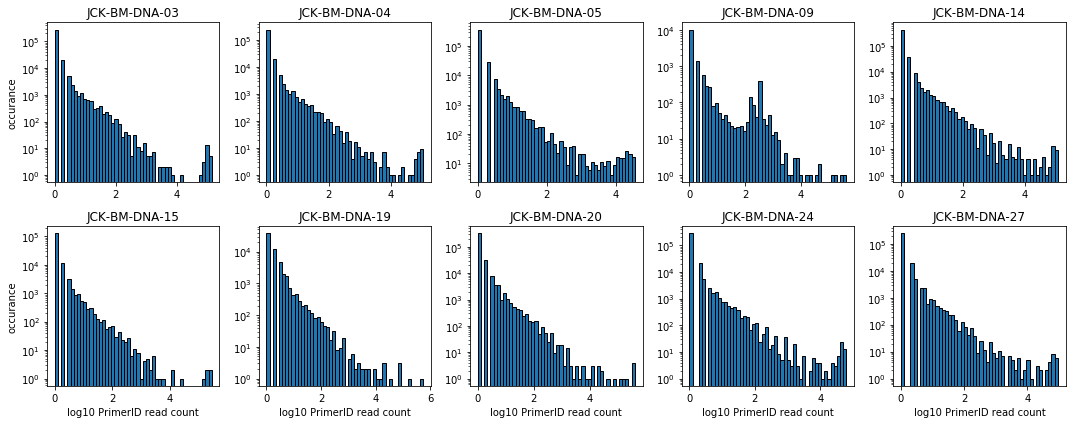

In [92]:
plt.figure(figsize=(15,6))
ploti = 0
thredict = {}
for sample in s2list:
    ploti += 1
    plt.subplot(2,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p2dict[sample].values())),edgecolor='black',bins=50)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 6: plt.xlabel('log10 PrimerID read count')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch2.png',dpi=600)

Except BM09, we cannot set clear cutoff for PrimerIDs. For convenience, we will just use the cutoff from BM09 to every other samples in this batch. I will paint all true PrimerID orange. It is OK to be conservative at the first few steps.

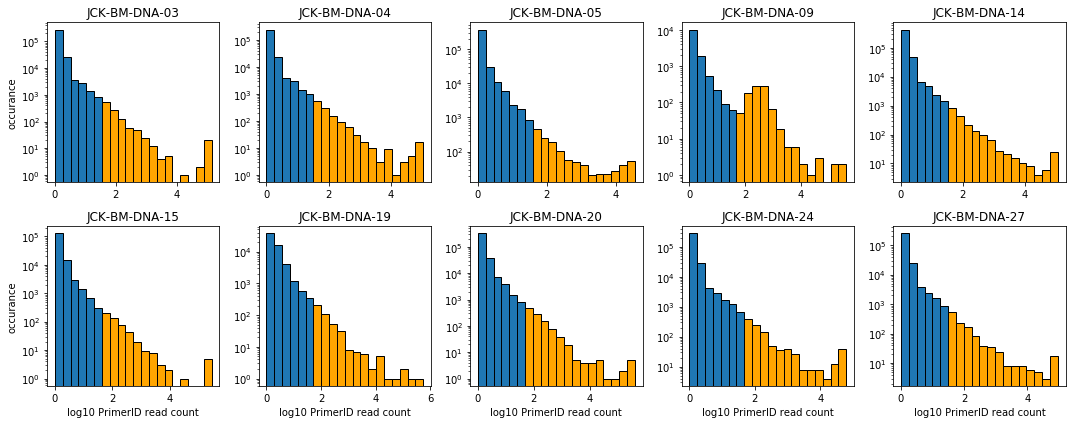

In [93]:
plt.figure(figsize=(15,6))
ploti = 0
t2dict = {}
for sample in s2list:
    ploti += 1
    plt.subplot(2,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p2dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 6: plt.xlabel('log10 PrimerID read count')
    for i in range(20):
        if bins[i] >=np.log10(30):
            patches[i].set_facecolor('orange')
    t2dict[sample] = 30
plt.tight_layout()
plt.savefig('PID_count_distribution_batch2.png',dpi=600)

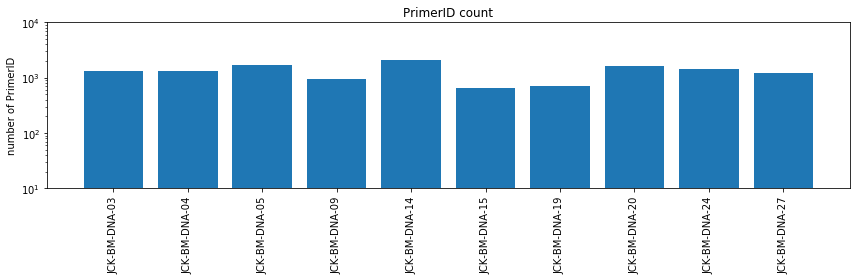

In [95]:
pidcountlist = []
for sample in s2list:
    countlist = list(p2dict[sample].values())
    pidcount = len([x for x in countlist if x > t2dict[sample]])
    pidcountlist.append(pidcount)
plt.figure(figsize=(12,4))
plt.bar(s2list,pidcountlist)
plt.yscale('log')
plt.title('PrimerID count')
plt.xticks(rotation=90)
plt.ylabel('number of PrimerID')
plt.ylim([1e1,1e4])
plt.tight_layout()
plt.savefig('PrimerID_count_batch2.png',dpi=600)

Each sample a few thousand valid PrimerIDs. Very good for downstream analysis.

**Re-sequencing suggestion:**  
Re-make every libraries except BM09, with less PCR cycles. But the priority is not high. For now we could still do reasonable analysis.

### batch3
JCK8 spleen

In [96]:
reffile = open('barcode/tag_batch3.txt')
tagdict = {}
for line in reffile:
    line = line.rstrip().rsplit('\t')
    tagdict[line[0]] = line[1]
reffile.close()
tagdict

{'CACAGT': 'Spleen_S3',
 'CGCGTC': 'Spleen_S4',
 'TATCGC': 'Spleen_S5',
 'TGTGCT': 'Spleen_S7',
 'TCATGA': 'Spleen_S9',
 'CGTAGC': 'Spleen_S14',
 'CGATGT': 'Spleen_S15',
 'AGTCAG': 'Spleen_S19',
 'GCTGAC': 'Spleen_S25'}

In [97]:
infiles = sorted(glob.glob('barcode/batch3/Undetermined_S0_R1_001_*.txt'))
p3dict = {}
for tag in tagdict:
    p3dict[tagdict[tag]] = {}
for infile in infiles:
    inhandle = open(infile)
    for line in inhandle:
        line = line.rstrip().rsplit('\t')
        tag  = line[0]
        if tag not in tagdict: continue
        pid  = line[2]
        sample = tagdict[tag]
        if pid not in p3dict[sample]: p3dict[sample][pid] = 0
        p3dict[sample][pid] += 1
    inhandle.close()

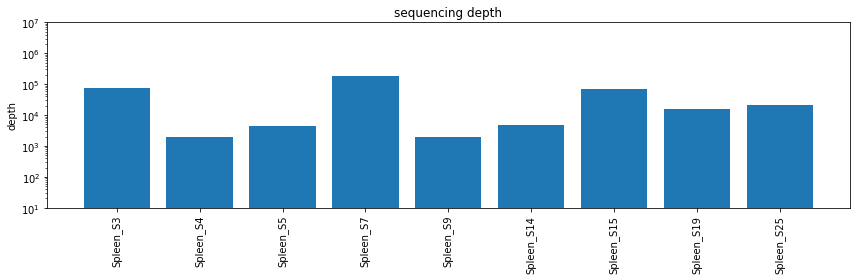

In [53]:
s3list = list(p3dict.keys())
depthlist = [sum(p3dict[x].values()) for x in s3list]
plt.figure(figsize=(12,4))
plt.bar(s3list,depthlist)
plt.yscale('log')
plt.title('sequencing depth')
plt.xticks(rotation=90)
plt.ylabel('depth')
plt.ylim([1e1,1e7])
plt.tight_layout()
plt.savefig('sequencing_depth_batch3.png',dpi=600)

This batch of samples have a few thousand reads each. Let's see if this is sufficent by looking at the PrimerID distribution.

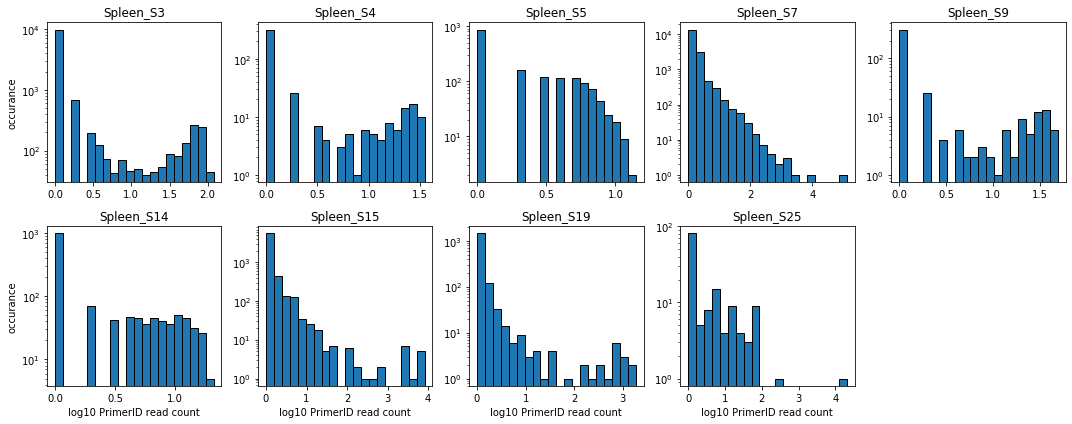

In [98]:
plt.figure(figsize=(15,6))
ploti = 0
thredict = {}
for sample in s3list:
    ploti += 1
    plt.subplot(2,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p3dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 6: plt.xlabel('log10 PrimerID read count')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch3.png',dpi=600)

Though not very deep, sequencing results still captured the main peaks in the frequency histogram, especially for S3, S4, S5, S9, S14 and S19. Let's have a detailed look ath these PrimerIDs to see if any of these if pariticularly insufficient.

In [100]:
sample = 'Spleen_S3'
toplist = sorted(p3dict[sample].items(), key=lambda kv:-kv[1])
for i in range(30):
    print(toplist[i])

('GGCGTGGAGAAAT', 119)
('TAGGAAATGAACT', 113)
('TAAGCACGGGGAT', 110)
('TGGCAGGAGCTGT', 109)
('GCCCACGATGTTT', 109)
('TGGGCAGGTCTTT', 107)
('TGGGTTCGGACAT', 104)
('TAAGACCGCCATT', 103)
('GTGCGCCCCTGTT', 103)
('TAGCATCTCTCAT', 103)
('GACGTAGTGCAGT', 103)
('GCGGTGGGGCAGT', 103)
('TCCATGACCCGTT', 102)
('CGCAAGATACGGT', 101)
('TAAGCCAAGTTGT', 101)
('GGTTGGGTCGTCT', 101)
('TAGTACTCATCTT', 100)
('GTGCAGGGTTGAT', 99)
('GAGCACGCATTTT', 99)
('TGACGGGAGCTAT', 99)
('TCAGCGCCGACGT', 99)
('ATCGGTTCGGGGT', 98)
('TGCCTTTTGTCGT', 98)
('TCGTGCCCTTGTT', 98)
('GCCTAAACGAAAT', 98)
('TCCAGTGTGAGTT', 97)
('TCTAGGTACTGAT', 97)
('TGGGTTGATGTAT', 97)
('GAACACGAGTTAT', 96)
('AGTCTGGTTAGTT', 96)


S3 is quite uniform.

In [101]:
sample = 'Spleen_S7'
toplist = sorted(p3dict[sample].items(), key=lambda kv:-kv[1])
for i in range(30):
    print(toplist[i])

('GGTGCTTACAATT', 126659)
('GCGTTCGGCGGTT', 10267)
('TTTTAGGGGTGAT', 2932)
('AAGAAGGTAGACT', 1699)
('AATTTAGTAATTT', 1606)
('TTCTTGTGGGATT', 1179)
('TCAGTCCGTTGAT', 1057)
('TGTAGTCACACAT', 949)
('GGTCAACATAGGT', 613)
('GGCACTACGGAAT', 565)
('GAGACCCCTGAAT', 513)
('AACATTGATCTAT', 387)
('ATGGGGGCATATT', 315)
('TCCGTTTCTCGGT', 304)
('GATCCGTCGGTGT', 234)
('GTTATTTTGGGAT', 226)
('GTAATTCGTTAGT', 225)
('ATTGTAATAAATT', 214)
('TCTCTGTTGGTCT', 209)
('TAAATATTGGTTT', 196)
('TGTTATGGGCTAT', 176)
('TGGGCAAGCTTGT', 165)
('CTGCGTTATGGGT', 162)
('GGTGTGAAGGGGT', 159)
('CAGAGACTGTGGT', 157)
('GGCCCTGAGCACT', 146)
('GGTGCTTACACTT', 143)
('TCAGGGGATACGT', 132)
('TAACGACTACTGT', 129)
('TAATACTTTCATT', 128)


The most abundance PrimerID has 127k reads. While the rest have less than one thousand. Note the 27th PrimerID is only 1 nucleotide different from the 1st one. This indicates the child-PrimerID resulting from sequencing errors has been mixed with true PrimerIDs. If we sequence deeper, we will get more error PrimerIDs for S7. 

In [103]:
sample = 'Spleen_S15'
toplist = sorted(p3dict[sample].items(), key=lambda kv:-kv[1])
for i in range(30):
    print(toplist[i])

('TTGTTAAGTTCAT', 8130)
('ATGTACCGTCCTT', 8024)
('TGTGCCTGGAGTT', 6234)
('TAGTTGTGTGCGT', 6057)
('AATACAATCATAT', 5510)
('TTAATCTGTTTAT', 4980)
('TCTGTGAAGCACT', 3201)
('TCCTTTGTCCAGT', 2868)
('TGCCTTGAAGACT', 2812)
('TCAGTAAATTTTT', 2473)
('ATTCTTCATAATT', 2304)
('ATATCGCTGAGCT', 2274)
('CGATCTGACCATT', 2120)
('TGTTTTCGCTTGT', 766)
('CGAATAATGCCGT', 639)
('TTGCAGTACAAGT', 384)
('TGCCGGTTACTGT', 346)
('ACGGTCGTCGGTT', 213)
('TTATCATATTGGT', 195)
('AAAGATGCCTCAT', 141)
('ACAGCTATCAGAT', 117)
('AGGCTAGTTGCGT', 101)
('TACGATCGTGGAT', 98)
('CCCGAGGAAAGAT', 94)
('TACCAGAAGACTT', 91)
('TCGACGCGCGGCT', 56)
('CTTAAGACTTGAT', 56)
('TTCAGCCATGCTT', 53)
('GTTTTGAACATAT', 44)
('TTATGAGTGAATT', 44)


In [104]:
sample = 'Spleen_S25'
toplist = sorted(p3dict[sample].items(), key=lambda kv:-kv[1])
for i in range(30):
    print(toplist[i])

('CGTCATACTTGTTT', 20060)
('TTTGTCGCTCAGT', 290)
('GATCTCTGTAGTT', 82)
('ATTAGAGAACTCT', 72)
('ATCAATTCAGTCT', 71)
('GGTTGCTAATCTT', 69)
('GGGTTTCATGTCT', 67)
('TTCATAGGTATTT', 66)
('CAGTAGTTAGGAT', 62)
('ACTTAGTAATTAT', 61)
('GGTCTACCGCTAT', 58)
('TCGAAATGTAGTT', 36)
('GTTATTCCTGTTT', 34)
('CCTAAACTTCTTT', 34)
('TATATAGTCTTTT', 30)
('CGGCAAAATTGCT', 30)
('CTATTTGGAATGT', 29)
('CGTCATCCTTGTTT', 21)
('AGTCATACTTGTTT', 19)
('CGTCATACGTGTTT', 17)
('CGTCATAATTGTTT', 17)
('CATCATACTTGTTT', 17)
('CGTCATACTTGGTT', 15)
('CGTCATACTTATTT', 14)
('CGTCATACTTGATT', 14)
('CGTCATACATGTTT', 12)
('CGTCATACTAGTTT', 12)
('CGGCATACTTGTTT', 10)
('CGTCATACTTGCTT', 10)
('CGTCATACCTGTTT', 9)


S15's top PrimerIDs are distinct, though their frequency varies hundreds fold.   
S25 clearly has a lot of child-PrimerID from sequencing error of the most abundant PrimerID.  

For now, I will set threshold for S3, S4, S5, S9, S14 with double peak method, and manually set threshold (5 reads) for S7, S15, S19, S25.

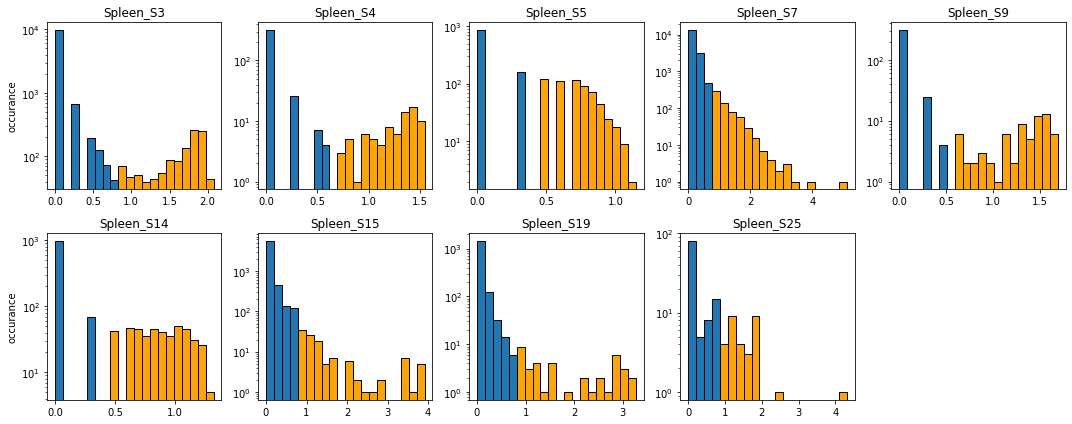

In [107]:
plt.figure(figsize=(15,6))
ploti = 0
t3dict = {}

manlist = ['Spleen_S7','Spleen_S15','Spleen_S19','Spleen_S25']
for sample in s3list:
    ploti += 1
    plt.subplot(2,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p3dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 11: plt.xlabel('log10 PrimerID read count')
    for i in range(6,19):
        if n[i+1] != 0 and n[i]/n[i+1] < 1 and n[i] >= 0:
            peaki = i
            break
    t3dict[sample] = (10**bins[peaki])
    if sample in manlist:
        t3dict[sample] = 5
    for i in range(20):
        if bins[i] > np.log10(t3dict[sample]):
            patches[i].set_facecolor('orange')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch3.png',dpi=600)

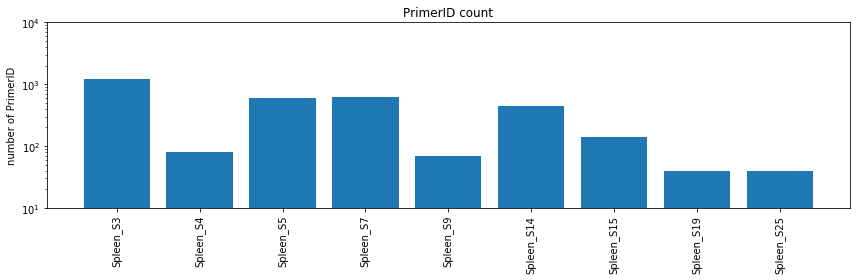

In [108]:
pidcountlist = []
for sample in s3list:
    countlist = list(p3dict[sample].values())
    pidcount = len([x for x in countlist if x > t3dict[sample]])
    pidcountlist.append(pidcount)
plt.figure(figsize=(12,4))
plt.bar(s3list,pidcountlist)
plt.yscale('log')
plt.title('PrimerID count')
plt.xticks(rotation=90)
plt.ylabel('number of PrimerID')
plt.ylim([1e1,1e4])
plt.tight_layout()
plt.savefig('PrimerID_count_batch3.png',dpi=600)

**Re-sequencing suggestion:**  
Sequence with higher depth (low priority):  
S4, S5, S9, S14  
Make library with more cDNA molecules:  
**S4, S9, S19, S25**

### batch4
JCK8 implant, terminal bleed

In [109]:
reffile = open('barcode/tag_batch4.txt')
tagdict = {}
for line in reffile:
    line = line.rstrip().rsplit('\t')
    tagdict[line[0]] = line[1]
reffile.close()
tagdict

{'AGAGCG': 'Implant3',
 'ACGATA': 'Implant9',
 'CTGACG': 'Implant15',
 'TCGAGC': 'Implant16',
 'GAGCTA': 'Implant24',
 'TATGAG': 'Implant27',
 'TAGATG': 'TerB4',
 'ATACAT': 'TerB5',
 'GTCGTA': 'TerB9',
 'ATATCA': 'TerB14',
 'GTGTGC': 'TerB20',
 'CATGTA': 'TerB24',
 'ATCAGC': 'TerB27'}

In [110]:
infiles = sorted(glob.glob('barcode/batch4/Undetermined_S0_R1_*.txt'))
p4dict = {}
for tag in tagdict:
    p4dict[tagdict[tag]] = {}
for infile in infiles:
    inhandle = open(infile)
    for line in inhandle:
        line = line.rstrip().rsplit('\t')
        tag  = line[0]
        if tag not in tagdict: continue
        pid  = line[2]
        sample = tagdict[tag]
        if pid not in p4dict[sample]: p4dict[sample][pid] = 0
        p4dict[sample][pid] += 1
    inhandle.close()

In [111]:
s4list = list(p4dict.keys())
depthlist = [sum(p4dict[x].values()) for x in s4list]

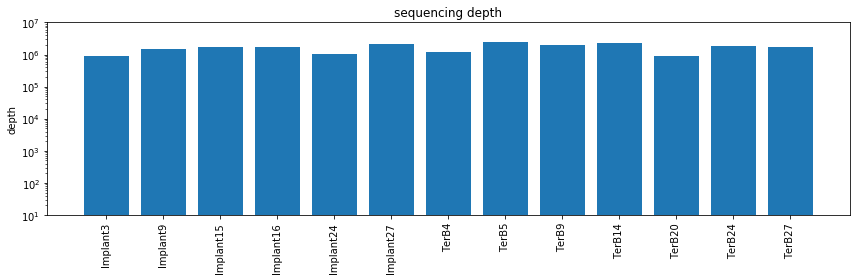

In [112]:
plt.figure(figsize=(12,4))
plt.bar(s4list,depthlist)
plt.yscale('log')
plt.title('sequencing depth')
plt.xticks(rotation=90)
plt.ylabel('depth')
plt.ylim([1e1,1e7])
plt.tight_layout()
plt.savefig('sequencing_depth_batch4.png',dpi=600)

A very legit sequencing batch.

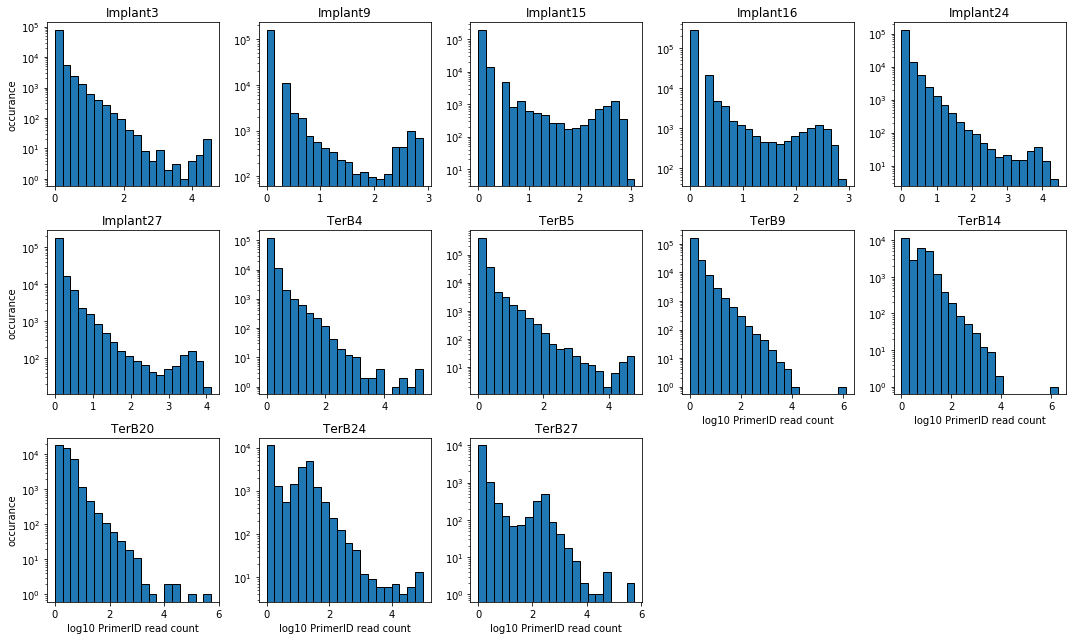

In [113]:
plt.figure(figsize=(15,9))
ploti = 0
thredict = {}
for sample in s4list:
    ploti += 1
    plt.subplot(3,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p4dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 9: plt.xlabel('log10 PrimerID read count')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch4.png',dpi=600)

Samples like Implant3, Implant9 have ideal double peaks. But the samples like Terminal Bleed 9 and 14 really concerns me. Let's look at some examples.

In [114]:
sample = 'TerB14'
toplist = sorted(p4dict[sample].items(), key=lambda kv:-kv[1])
for i in range(40):
    print(toplist[i])

('TTTGACCGGGATT', 1877304)
('CTGGGACCAACGT', 6978)
('AATCCGGTGCAAT', 6285)
('CTTGACCGGGATT', 5216)
('GTTATAGGACATT', 4092)
('ATACACCGGGTTT', 3557)
('TTCTTCACTGTTT', 3283)
('GTGTAAACGTGGT', 3257)
('TTCTGACATTCTT', 3226)
('TGCTACTCGAGAT', 3022)
('CAGCGTCCCTTCT', 2961)
('TTTTTATATCGAT', 2838)
('CTAACGTATGGTT', 2773)
('GTGTACTCATATT', 2737)
('GTCTGAAGCGAGT', 2417)
('TTTGACCGGGGTT', 2237)
('TTTCATTCGAGTT', 2059)
('CTGAAAGGCAATT', 1675)
('GGTGCGGAGTTGT', 1644)
('AAGATTACAATAT', 1640)
('GAACTATACTGTT', 1591)
('TTCGAGTGATGCT', 1528)
('GTGAAAGGCTCCT', 1465)
('ACAGCCGCTTTAT', 1395)
('TTTGACCGGGCTT', 1293)
('GGAAGCGTCCTAT', 1290)
('TTAGGTTCGACTT', 1282)
('TTGCGTACCATTT', 1273)
('TAGGACGACTTCT', 1224)
('TTTGAACGGGATT', 1152)
('TTTTACCGGGATT', 1062)
('TTGGTGCAGGCGT', 1023)
('TCTACAAATGTCT', 941)
('TTTGAGCGGGATT', 911)
('TTTGATCGGGATT', 889)
('TTTAACCGGGATT', 878)
('GGATCTAGTTCAT', 858)
('TTTGTTTCTACAT', 854)
('ACTGGCGTCGCAT', 851)
('TTTGACAGGGATT', 849)


A lot of PrimerIDs are the child-PrimerID of the most abundant one. But there are also many true PrimerIDs. I will set the threshold of 1000 count for TerB14.

In [115]:
sample = 'TerB9'
toplist = sorted(p4dict[sample].items(), key=lambda kv:-kv[1])
for i in range(30):
    print(toplist[i])

('AACCTCATTTATT', 1311627)
('TCGCGAATCATCT', 13616)
('CTGACTCCTGGAT', 8349)
('TACGTGACTGATT', 7211)
('CATCAGATTAGTT', 5183)
('TTTTGTTTAAGAT', 4862)
('GCTTGTTAAACAT', 3884)
('TGCAATATCAACT', 3753)
('TACGTGTAAAATT', 3305)
('ATCGAAATACAGT', 2898)
('ATTATAATTTAGT', 2719)
('TGAAGACTTTTGT', 2612)
('AACTACGTTGCAT', 2422)
('AACCTCATGTATT', 2231)
('CTTGGTGTGTGAT', 1848)
('CTAGTTTCAGATT', 1701)
('TGATTCAAGTTGT', 1524)
('GACCTCTGAAAAT', 1493)
('GTATTTGGATGAT', 1455)
('TACTCATTCATAT', 1431)
('GACAAGGGTATGT', 1356)
('TTCTTGAGATCAT', 1344)
('TTGATTGTTAAGT', 1313)
('AACCTCATTTCTT', 1279)
('TCATACCCTTACT', 1262)
('TAGTGATTAGGTT', 1244)
('ACCTCTAGGTTAT', 1235)
('GTTGTCTGTTTCT', 1225)
('GGAAGGCCAGTAT', 1219)
('ATTGTTCTTGTGT', 1181)


Look the 2231 reads PrimerID, it is the error PrimerID.

In [116]:
sample = 'Implant9'
toplist = sorted(p4dict[sample].items(), key=lambda kv:-kv[1])
for i in range(40):
    print(toplist[i])

('TCGTCCGTGGTAT', 789)
('TGGCAAGTACGGT', 786)
('GCCTGAGGAAGTT', 782)
('TTTTCGACGTCAT', 776)
('TCGCCTGATTCT', 772)
('GATGACTGCACGT', 759)
('TGTCATGTAGTCT', 748)
('TATTAAGCGGAGT', 747)
('TTGTGGTGTCCAT', 731)
('TCGTCCGCTTCGT', 730)
('TTTGCGCTGGGAT', 730)
('GACCTGGATCCTT', 727)
('TGTGCAGATGGTT', 727)
('CTTAGTCAATCAT', 724)
('TCCCTAGCCGTGT', 723)
('CACGTTCAGACGT', 716)
('TGACGTAGGGTAT', 715)
('TCGCCTGCGTTTT', 715)
('TCGGAGCAGACGT', 709)
('TAGAGTGTTTGAT', 703)
('TCTCGATTCGTGT', 702)
('TGCTCTCCCACCT', 702)
('TGGTGGCTGACAT', 698)
('TCATGACATAGCT', 698)
('TACGTCAGTCAGT', 698)
('ATTGCCCGGCCCT', 695)
('TGTTTGGGCAAGT', 695)
('GGAGGCAGGCTGT', 692)
('TCCTTGGACAACT', 691)
('CAATTCTTGGACT', 688)
('TATAACTGCAGAT', 687)
('TGACCCGGGGTTT', 687)
('TTAGACACGCGGT', 686)
('TGGATGGAGGGTT', 686)
('TAGGGAGTCGAGT', 686)
('TGCACAACGGGTT', 685)
('TGTTGTGTGTATT', 684)
('GCCAGGATGGCTT', 681)
('TGGCTCATTTTAT', 681)
('GGGTCACTGGATT', 681)


This sample (Implant9) has the ideal PrimerID distribution.

So I will set the threshold for Implant samples using bi-peak algorithm. But for the rest, I will use the 1000 count cutoff.

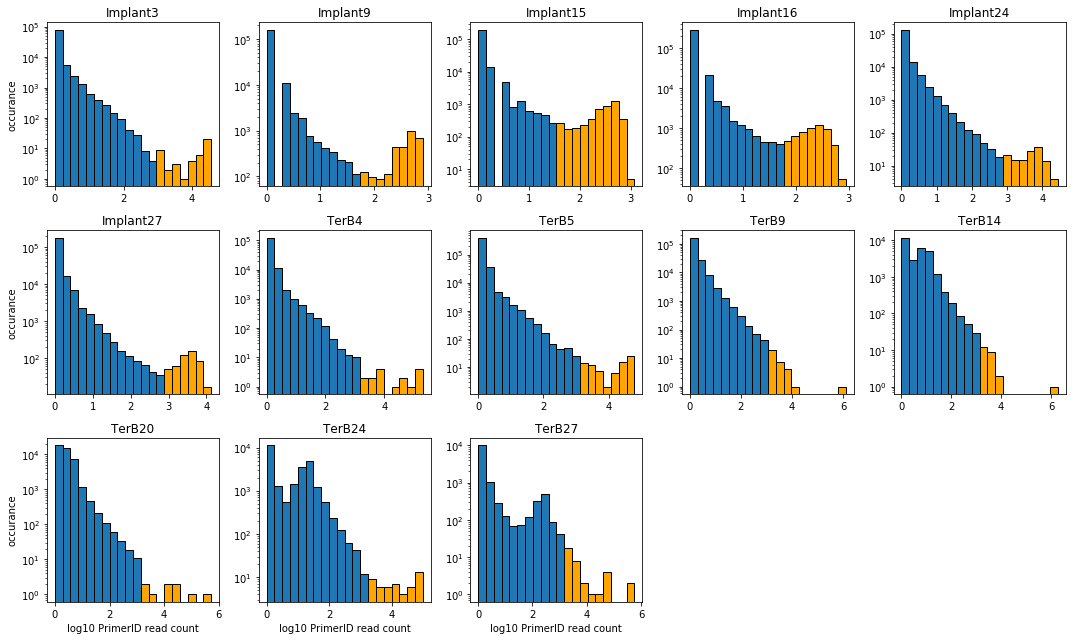

In [118]:
plt.figure(figsize=(15,9))
ploti = 0
t4dict = {}

for sample in s4list:
    ploti += 1
    plt.subplot(3,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p4dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 11: plt.xlabel('log10 PrimerID read count')
    for i in range(6,19):
        if n[i+1] != 0 and n[i]/n[i+1] < 1 and n[i] >= 0:
            peaki = i
            break
    t4dict[sample] = (10**bins[peaki])
    if 'TerB' in sample:
        t4dict[sample] = 1000
    for i in range(20):
        if bins[i] > np.log10(t4dict[sample]):
            patches[i].set_facecolor('orange')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch4.png',dpi=600)

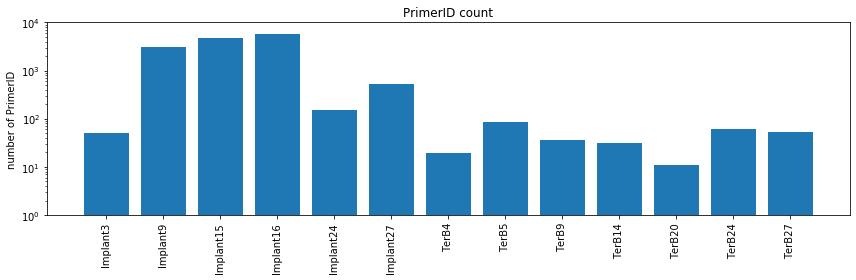

In [120]:
pidcountlist = []
for sample in s4list:
    countlist = list(p4dict[sample].values())
    pidcount = len([x for x in countlist if x > t4dict[sample]])
    pidcountlist.append(pidcount)
plt.figure(figsize=(12,4))
plt.bar(s4list,pidcountlist)
plt.yscale('log')
plt.title('PrimerID count')
plt.xticks(rotation=90)
plt.ylabel('number of PrimerID')
plt.ylim([1e0,1e4])
plt.tight_layout()
plt.savefig('PrimerID_count_batch4.png',dpi=600)

Most implant samples are good. But the rest are also sufficient for analysis.

**Re-sequencing suggestion:**  
Make library with more cDNA molecules:  
**TerB4, TerB9, TerB14, TerB20**, Implant3

### batch5
JCK8 Implant, Spleen, preART
JCK11 Implant

In [121]:
reffile = open('barcode/tag_batch5.txt')
tagdict = {}
for line in reffile:
    line = line.rstrip().rsplit('\t')
    tagdict[line[0]] = line[1]
reffile.close()
tagdict

{'CACAGT': 'JCK8_PreART_Bleed_S3',
 'CGCGTC': 'JCK8_PreART_Bleed_S4',
 'TATCGC': 'JCK8_PreART_Bleed_S7',
 'TGTGCT': 'JCK8_PreART_Bleed_S8',
 'TCATGA': 'JCK8_PreART_Bleed_S9',
 'CGTAGC': 'JCK8_PreART_Bleed_S10',
 'CGATGT': 'JCK8_PreART_Bleed_S11',
 'AGTCAG': 'JCK8_PreART_Bleed_S12',
 'GCTGAC': 'JCK8_PreART_Bleed_S13',
 'ACGCGT': 'JCK8_PreART_Bleed_S14',
 'GCACAG': 'JCK8_PreART_Bleed_S16',
 'ACGTAG': 'JCK8_PreART_Bleed_S17',
 'AGAGCG': 'JCK8_PreART_Bleed_S18',
 'ACGATA': 'JCK8_PreART_Bleed_S19',
 'CTGACG': 'JCK8_PreART_Bleed_S20',
 'TCGAGC': 'JCK8_PreART_Bleed_S24',
 'GAGCTA': 'JCK8_PreART_Bleed_S27',
 'TATGAG': 'JCK8_PreART_wk4_S5',
 'TAGATG': 'JCK8_PreART_wk4_S25',
 'ATACAT': 'JCK8_PreART_wk4_S26',
 'GTCGTA': 'JCK8_Implant_S5',
 'ATATCA': 'JCK8_Implant_S14',
 'GTGTGC': 'JCK8_spleen_S16',
 'CATGTA': 'JCK8_spleen_S20',
 'ATCAGC': 'JCK8_spleen_S26',
 'TCTCTA': 'JCK8_spleen_S27',
 'TACTAT': 'JCK11_Implant_S1',
 'CACTCG': 'JCK11_Implant_S2',
 'GAGACT': 'JCK11_Implant_S3',
 'GCAGCA': 'JCK11_

In [122]:
len(tagdict)

41

In [126]:
infiles = sorted(glob.glob('barcode/batch5/Undetermined_S0_R1_*.txt'))
p5dict = {}
for tag in tagdict:
    p5dict[tagdict[tag]] = {}
for infile in infiles:
    inhandle = open(infile)
    for line in inhandle:
        line = line.rstrip().rsplit('\t')
        tag  = line[0]
        if tag not in tagdict: continue
        pid  = line[2]
        sample = tagdict[tag]
        if pid not in p5dict[sample]: p5dict[sample][pid] = 0
        p5dict[sample][pid] += 1
    inhandle.close()

In [127]:
s5list = list(p5dict.keys())
depthlist = [sum(p5dict[x].values()) for x in s5list]

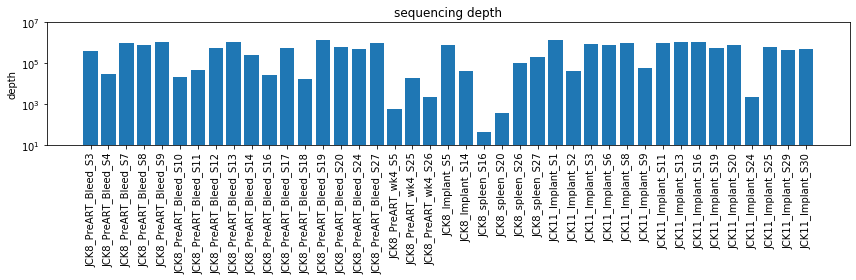

In [128]:
plt.figure(figsize=(12,4))
plt.bar(s5list,depthlist)
plt.yscale('log')
plt.title('sequencing depth')
plt.xticks(rotation=90)
plt.ylabel('depth')
plt.ylim([1e1,1e7])
plt.tight_layout()
plt.savefig('sequencing_depth_batch5.png',dpi=600)

Some JCK8 spleen samples has low read depth.

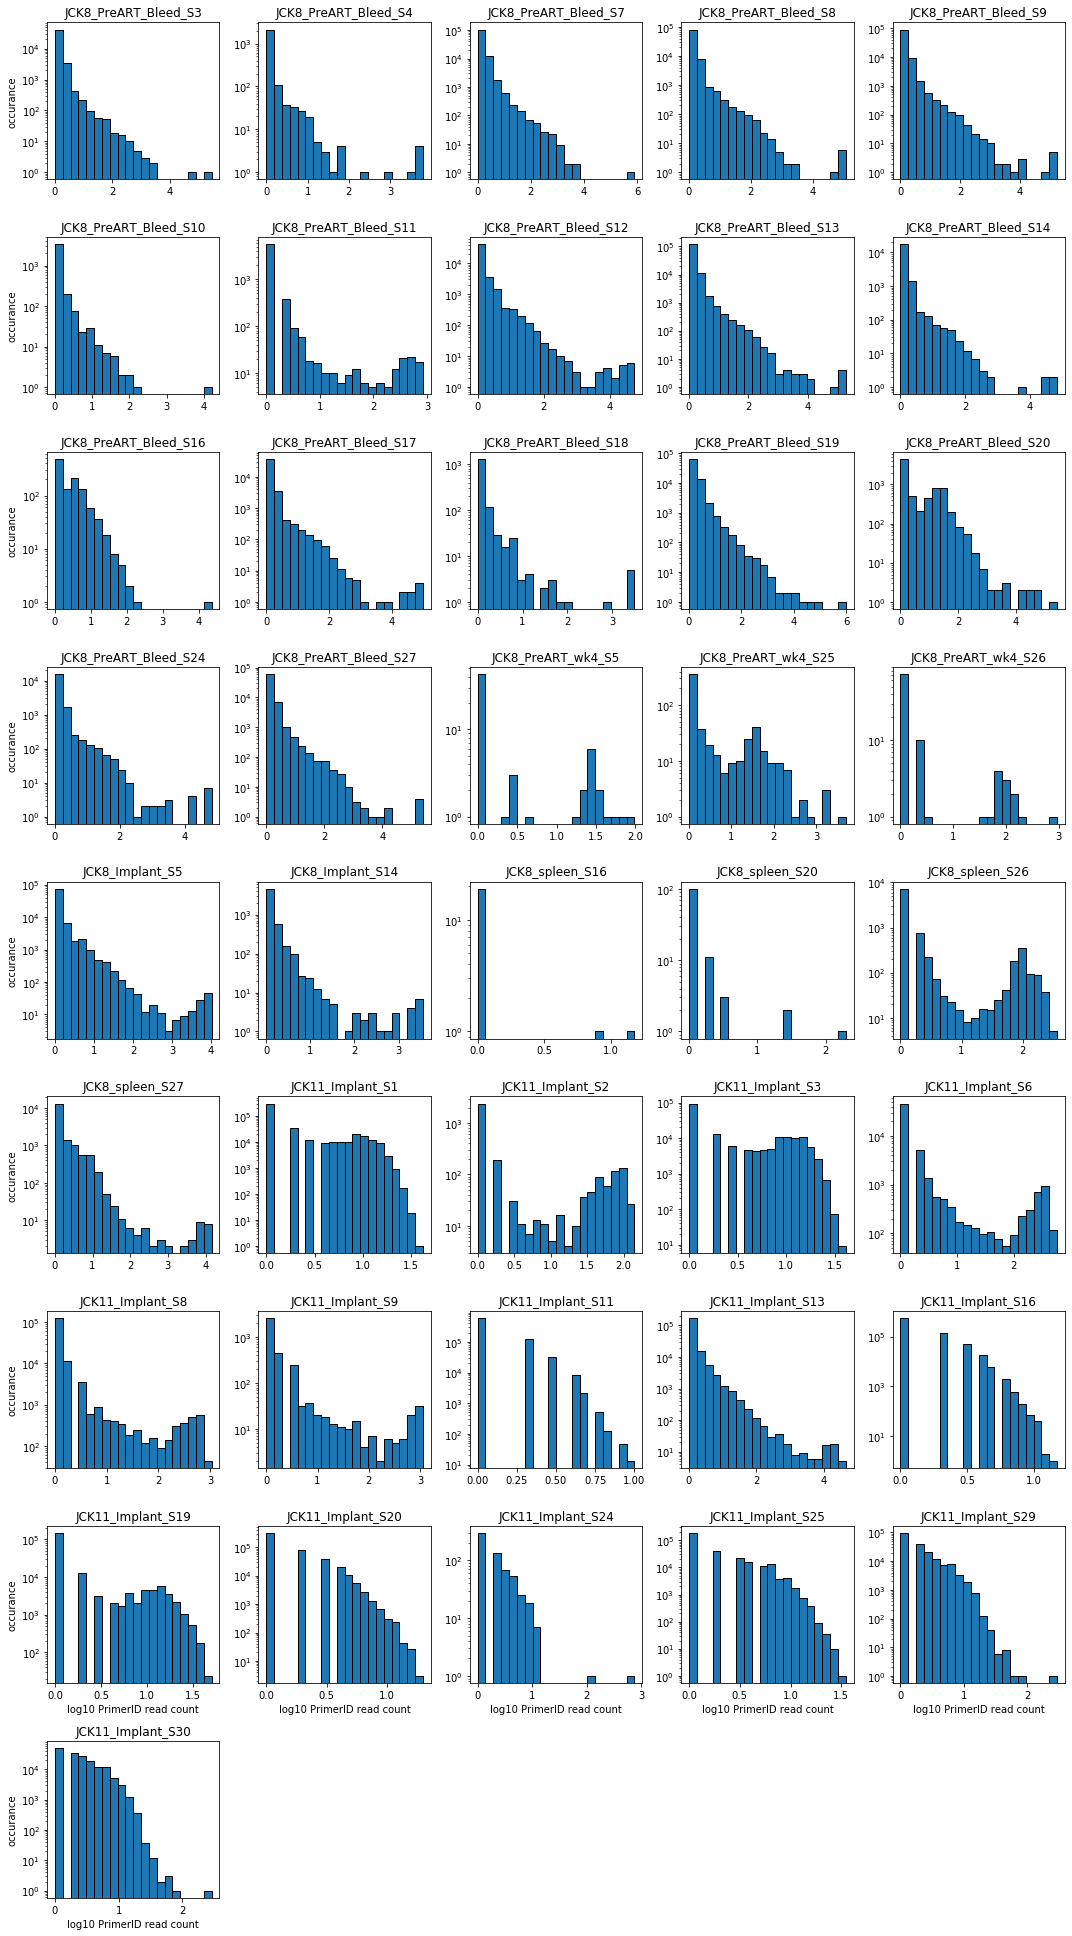

In [129]:
plt.figure(figsize=(15,27))
ploti = 0
thredict = {}
for sample in s5list:
    ploti += 1
    plt.subplot(9,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p5dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 36: plt.xlabel('log10 PrimerID read count')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch5.png',dpi=600)

Still, I think over-amplification is still a major concern of the library prep.   
Samples like JCK11_Implant_S8 and JCK11_Implant_S9 are good examples becuase high abundant PrimerIDs have uniform distribution.   
But samples like JCK8_perART_bleed_S10 and S16 are quite confusing. Because they have a very abundant PrimerID, whose frequency is thousands fold higher than rest PrimerIDs. 
Let's see some examples.

In [131]:
sample = 'JCK8_PreART_Bleed_S10'
toplist = sorted(p5dict[sample].items(), key=lambda kv:-kv[1])
for i in range(40):
    print(toplist[i])

('TTCCTTAGGTAGT', 16034)
('TGGTAAGTTGTAT', 162)
('ACCCCGCGGTTTT', 98)
('GTAACGGGCAGTT', 92)
('TCCAGCCCAATTT', 63)
('TGATAAACATAAT', 53)
('GGTACTAAGACTT', 47)
('TTGACCTCATTAT', 42)
('ATCCTTAGGTAGT', 38)
('AGGAGGACAATTT', 38)
('GGTCGTGGGGAGT', 31)
('CCCACTGGGATTT', 31)
('TTCATTCAAACAT', 29)
('GGGCTATGATAAT', 25)
('TATATGGTTCTCT', 24)
('TTACTTAGGTAGT', 23)
('TTCATTAGGTAGT', 21)
('TGGAGTGCTGCAT', 19)
('CCTCCCTGAATA', 19)
('TATACACCATAAT', 18)
('TCCTATGTTAACT', 17)
('AAAATATTGTGCT', 17)
('TTCCTTAGGGAGT', 16)
('GCTTTGTAGGTGT', 16)
('TTTGTCGTAAGAT', 16)
('TTCGTTAGGTAGT', 15)
('TTCCTTAGGAAGT', 14)
('TTCCTTAGGTCGT', 13)
('CTCCTTAGGTAGT', 13)
('TACCTTAGGTAGT', 12)
('TCAACTTTTTGAT', 11)
('GTTGTACGCGTAT', 11)
('TGCCTTAGGTAGT', 11)
('ACACAAAGGTTGT', 10)
('ATTGTTTAGTTAT', 10)
('TTCTTTAGGTAGT', 10)
('ATAGTATCATATT', 9)
('CTACAGAAGGATT', 9)
('AGGGGTTCAGGAT', 9)
('GCGCCGAGGTGGT', 9)


I will make the following criteria to set a threshold for batch5. It is also compatible with previous batches.
1. If the PrimerID read depth has a clear 2-peak distribution, the threshold read count will be between the 2 peaks.
2. Otherwise, if the most abundant PrimerID is more than 5000 reads, the threshold will be 1/1000 of the most abuanant PrimerID.
3. Otherwise, the threshold is 5.

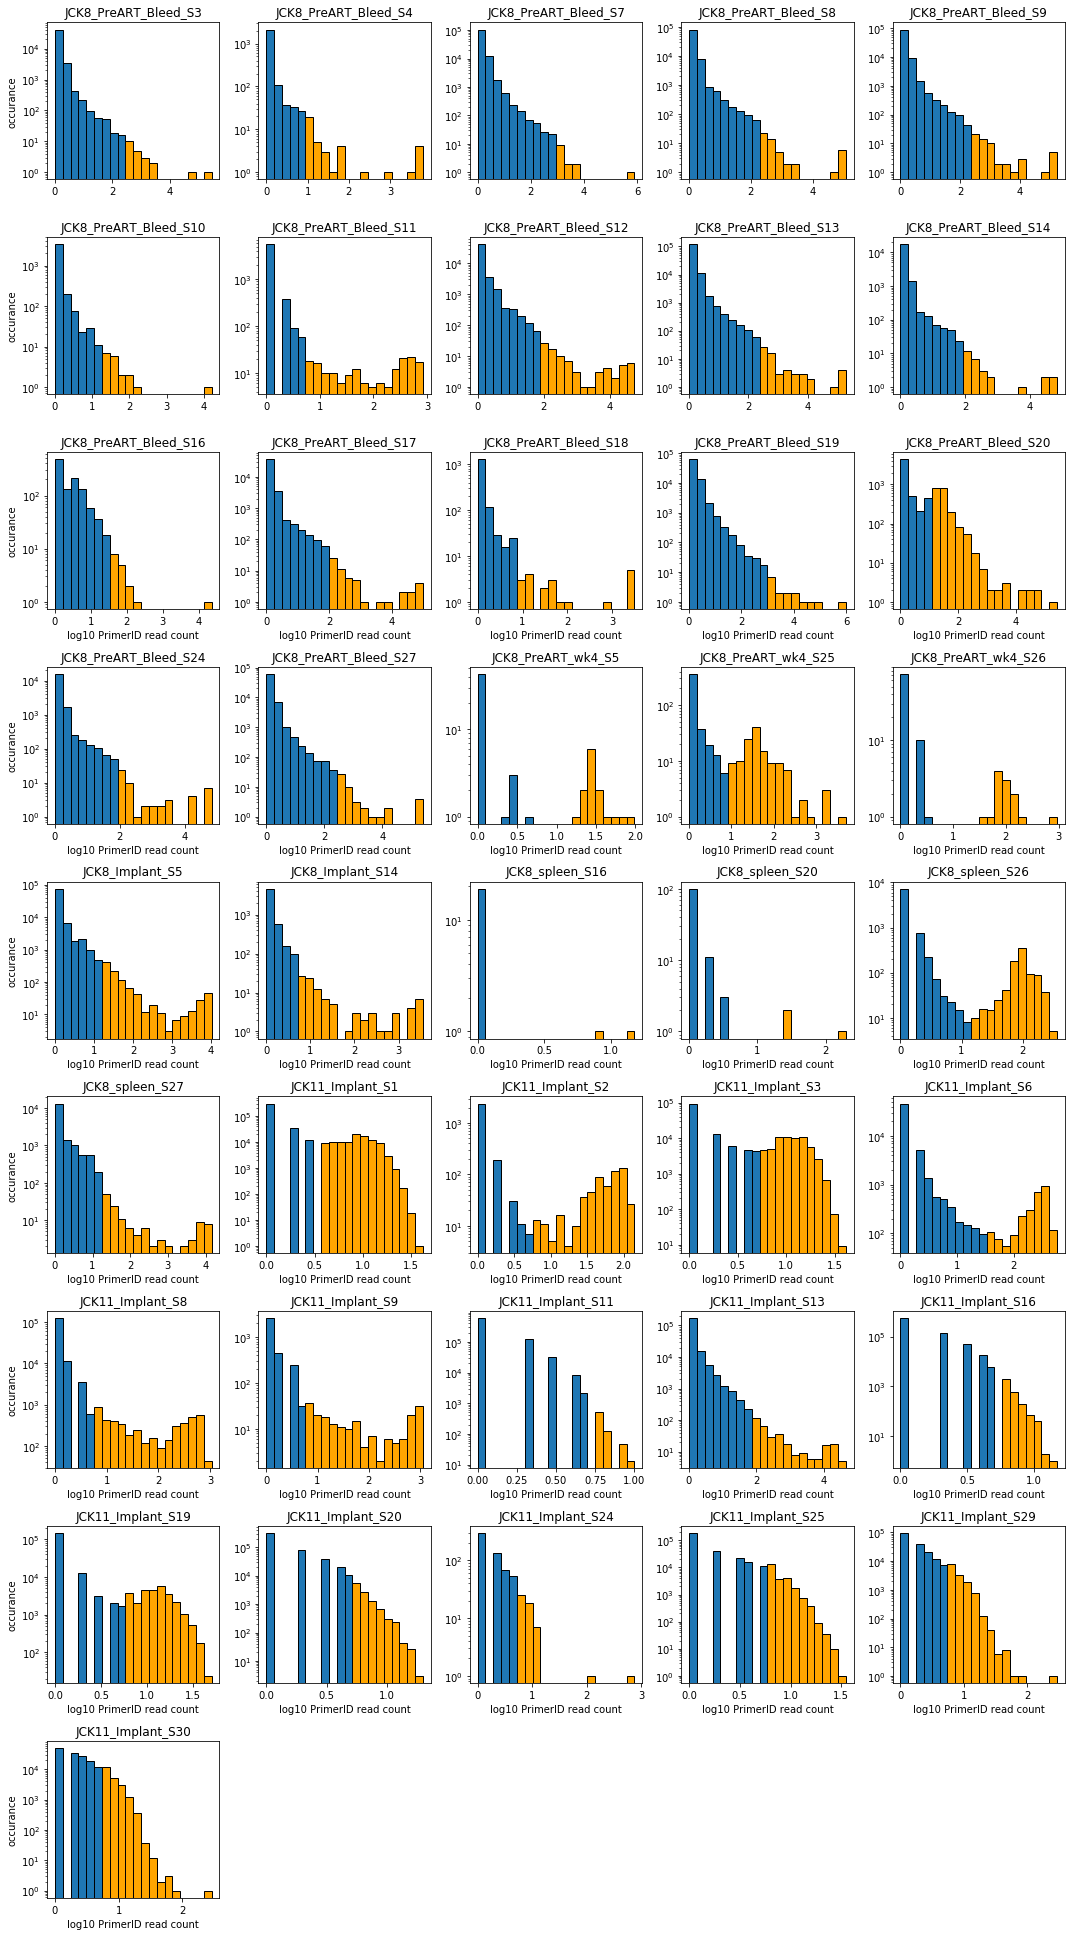

In [135]:
autolist = ['JCK8_PreART_Bleed_S20','JCK8_PreART_wk4_S25','JCK8_spleen_S26','JCK11_Implant_S1','JCK11_Implant_S2','JCK11_Implant_S3','JCK11_Implant_S6','JCK11_Implant_S8','JCK11_Implant_S9','JCK11_Implant_S19']

plt.figure(figsize=(15,27))
ploti = 0
t5dict = {}

for sample in s5list:
    ploti += 1
    plt.subplot(9,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p5dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 11: plt.xlabel('log10 PrimerID read count')
    for i in range(3,19):
        if n[i+1] != 0 and n[i]/n[i+1] < 1 and n[i] >= 1:
            peaki = i
            break
    top1count = sorted(p5dict[sample].items(), key=lambda kv:-kv[1])[0][1]
    if sample in autolist:
        t5dict[sample] = (10**bins[peaki])
    elif top1count > 5000:
        t5dict[sample] = top1count/1000
    else:
        t5dict[sample] = 5
    for i in range(20):
        if bins[i] > np.log10(t5dict[sample]):
            patches[i].set_facecolor('orange')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch5.png',dpi=600)

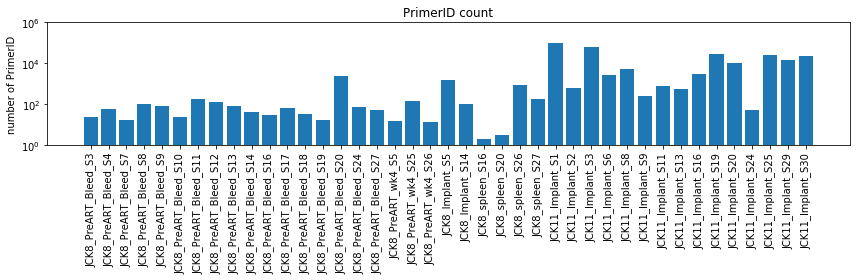

In [137]:
pidcountlist = []
for sample in s5list:
    countlist = list(p5dict[sample].values())
    pidcount = len([x for x in countlist if x > t5dict[sample]])
    pidcountlist.append(pidcount)
plt.figure(figsize=(12,4))
plt.bar(s5list,pidcountlist)
plt.yscale('log')
plt.title('PrimerID count')
plt.xticks(rotation=90)
plt.ylabel('number of PrimerID')
plt.ylim([1e0,1e6])
plt.tight_layout()
plt.savefig('PrimerID_count_batch5.png',dpi=600)

Implant samples are generally good. But the PrimerID numbers of spleen samples and preART bleed is low. Remember these numbers are already over-estimated, because I used very conservative threshold. The actual number of cDNA molecules went through the PrimerID protocol could be ~10 fold lower.

**Re-sequencing suggestion:**  
Make library with more cDNA molecules:    
**JCK8_spleen_S16**  
**JCK8_spleen_S20**  
**JCK11_Implant_S24** could be sequenced with higher depth.  
All JCK8_PreART samples could also be repeated with more input, but not with top priorities.



### batch6
JCK11 Bone Marrow and Terminal Bleed

In [144]:
reffile = open('barcode/tag_batch6.txt')
tagdict = {}
for line in reffile:
    if 'CD4' in line: continue
    line = line.rstrip().rsplit('\t')
    tagdict[line[0]] = line[1]
reffile.close()
tagdict

{'CACAGT': 'JCK11_TerB_S1',
 'CGCGTC': 'JCK11_TerB_S2',
 'TATCGC': 'JCK11_TerB_S3',
 'TGTGCT': 'JCK11_TerB_S6',
 'TCATGA': 'JCK11_TerB_S7',
 'CGTAGC': 'JCK11_TerB_S9',
 'CGATGT': 'JCK11_TerB_S11',
 'AGTCAG': 'JCK11_TerB_S14',
 'GCTGAC': 'JCK11_TerB_S16',
 'ACGCGT': 'JCK11_TerB_S20',
 'GCACAG': 'JCK11_TerB_S24',
 'ACGTAG': 'JCK11_TerB_S25',
 'AGAGCG': 'JCK11_TerB_S28',
 'ACGATA': 'JCK11_TerB_S29',
 'CTGACG': 'JCK11_TerB_S30',
 'CACTCG': 'JCK11_BM_S1',
 'GAGACT': 'JCK11_BM_S2',
 'GCAGCA': 'JCK11_BM_S3',
 'AGATAC': 'JCK11_BM_S6',
 'AGCTCT': 'JCK11_BM_S7',
 'TCAGTC': 'JCK11_BM_S9',
 'TGACTG': 'JCK11_BM_S11',
 'ATGCTG': 'JCK11_BM_S14',
 'CTGTAT': 'JCK11_BM_S16',
 'CATCAT': 'JCK11_BM_S19',
 'CTAGTG': 'JCK11_BM_S20',
 'CAGTGA': 'JCK11_BM_S24',
 'AGCATG': 'JCK11_BM_S25',
 'ACTACT': 'JCK11_BM_S29',
 'AGACGA': 'JCK11_BM_S30'}

In [145]:
infiles = sorted(glob.glob('barcode/batch6/Undetermined_S0_R1_*.txt'))
p6dict = {}
for tag in tagdict:
    p6dict[tagdict[tag]] = {}
for infile in infiles:
    inhandle = open(infile)
    for line in inhandle:
        line = line.rstrip().rsplit('\t')
        tag  = line[0]
        if tag not in tagdict: continue
        pid  = line[2]
        sample = tagdict[tag]
        if pid not in p6dict[sample]: p6dict[sample][pid] = 0
        p6dict[sample][pid] += 1
    inhandle.close()

In [146]:
s6list = list(p6dict.keys())
depthlist = [sum(p6dict[x].values()) for x in s6list]

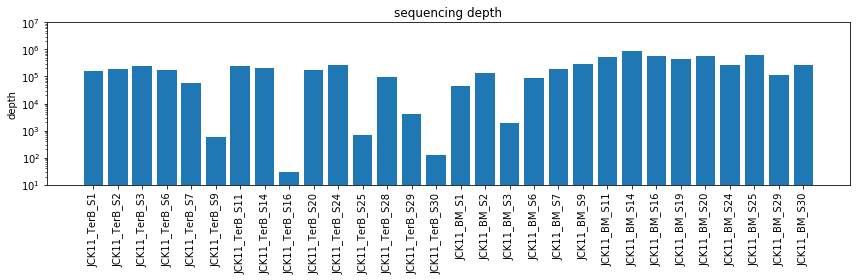

In [147]:
plt.figure(figsize=(12,4))
plt.bar(s6list,depthlist)
plt.yscale('log')
plt.title('sequencing depth')
plt.xticks(rotation=90)
plt.ylabel('depth')
plt.ylim([1e1,1e7])
plt.tight_layout()
plt.savefig('sequencing_depth_batch6.png',dpi=600)

JCK11_TerB_S9, JCK11_TermB_S16, JCK11_TerB_S25, JCK11_TermB_S30 has particularly low read depth. The rest should be sufficient.

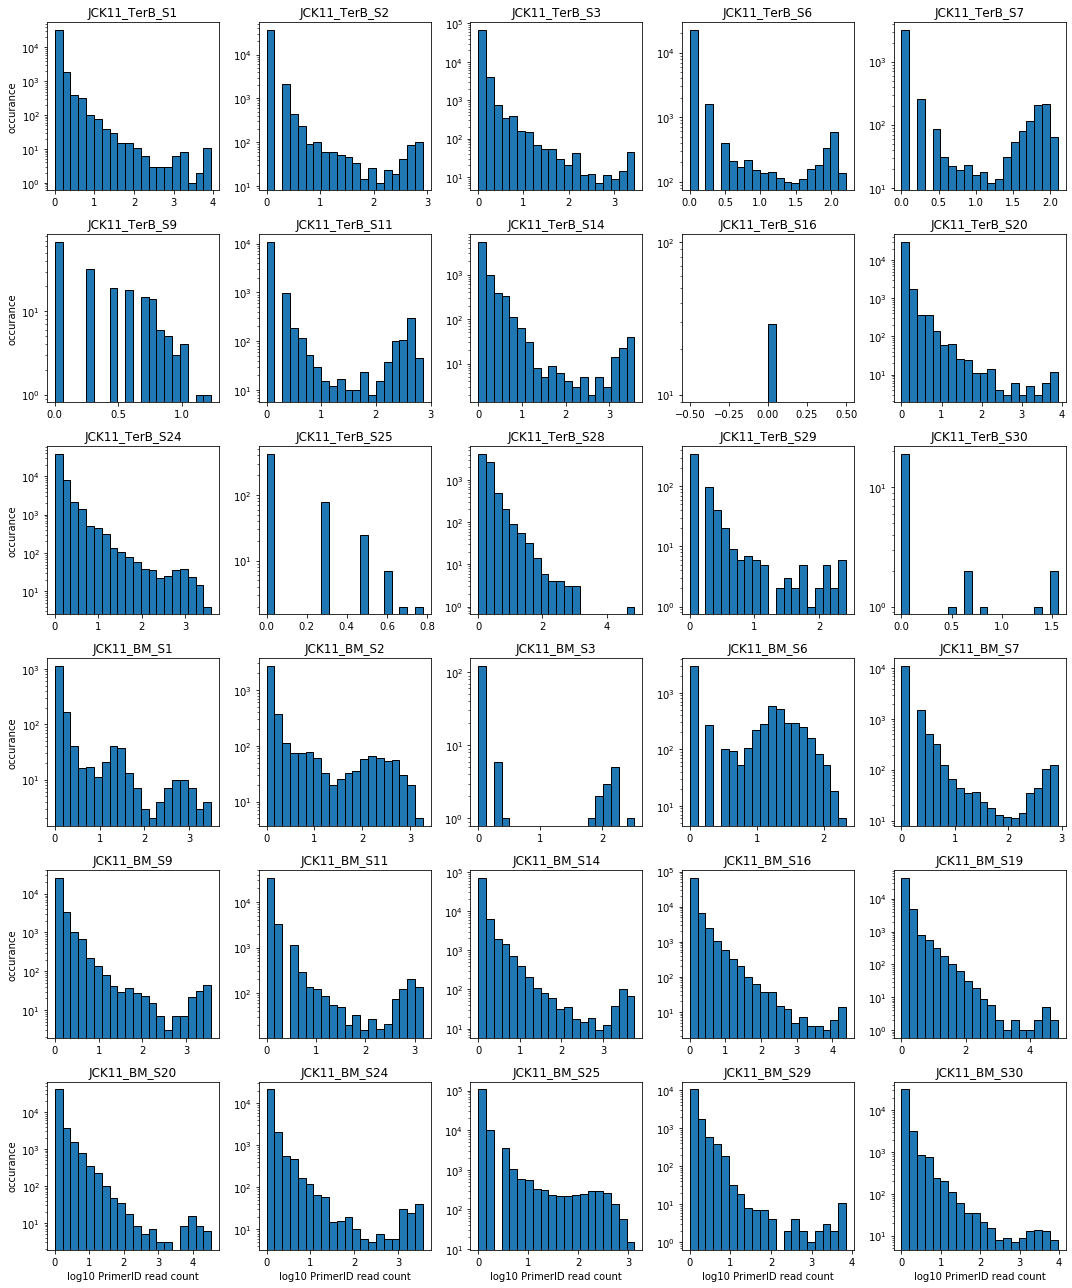

In [148]:
plt.figure(figsize=(15,18))
ploti = 0
for sample in s6list:
    ploti += 1
    plt.subplot(6,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p6dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 26: plt.xlabel('log10 PrimerID read count')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch6.png',dpi=600)

Still, we have multi-peak read count distribution. According to previous experience, they may not only come from sequencing errors, but also come from PCR over-amplifications. Let's have a look at some examples.

In [149]:
sample = 'JCK11_BM_S3'
toplist = sorted(p6dict[sample].items(), key=lambda kv:-kv[1])
for i in range(40):
    print(toplist[i])

('TGTCAGTGAAGTT', 330)
('CCGTTGACAGACT', 176)
('CCAAAGAACAGTT', 160)
('AGTATACGTTCAT', 141)
('AAACAAAATCGGT', 139)
('GGATGAACGAGTT', 139)
('CGATAGTCTAGAT', 136)
('CATTTGTTAACGT', 128)
('AAATTGTATTCGT', 107)
('GGCCACAATCGTT', 92)
('GGTGCACCAACGT', 82)
('AGGTTTTCGTGTT', 65)
('TGTCAGTGCAGTT', 3)
('TTTCCGTTGGGCT', 2)
('CAACAAAATCGGT', 2)
('ATATTGAATTACT', 2)
('GATACGACGTTTT', 2)
('ATCCTACGGAGCT', 2)
('CGCCACAATCGTT', 2)
('TCCAATGCATGTT', 1)
('ACGAGACCCATAT', 1)
('GCACAGGGGTCGT', 1)
('TGTCAGCGAAGTT', 1)
('ACTCAATAGGAGT', 1)
('CCTTCGTTAACGT', 1)
('AGGTTTTCGCGTT', 1)
('AGTCCATTATCGT', 1)
('GCTCGTCTTTTAT', 1)
('ATGCGAGAAAGAT', 1)
('CCTTGTCTGCCAT', 1)
('GATCCTTTTCCTT', 1)
('TCCAGGTCAAGTT', 1)
('GTTGACAGACT', 1)
('GCGATGGTCAAAT', 1)
('CATTTGTTACCGT', 1)
('CGATGAACGAGTT', 1)
('GATATGTGCTTAT', 1)
('TAAAGGCCTACTT', 1)
('CATTCATGTGCTT', 1)
('TTTCCGAGTGAGT', 1)


Some PrimerIDs are unique and some PrimerIDs are from sequencing errors (like TGTCAGTGCAGTT). I would still use the criteria for batch5 in this batch.

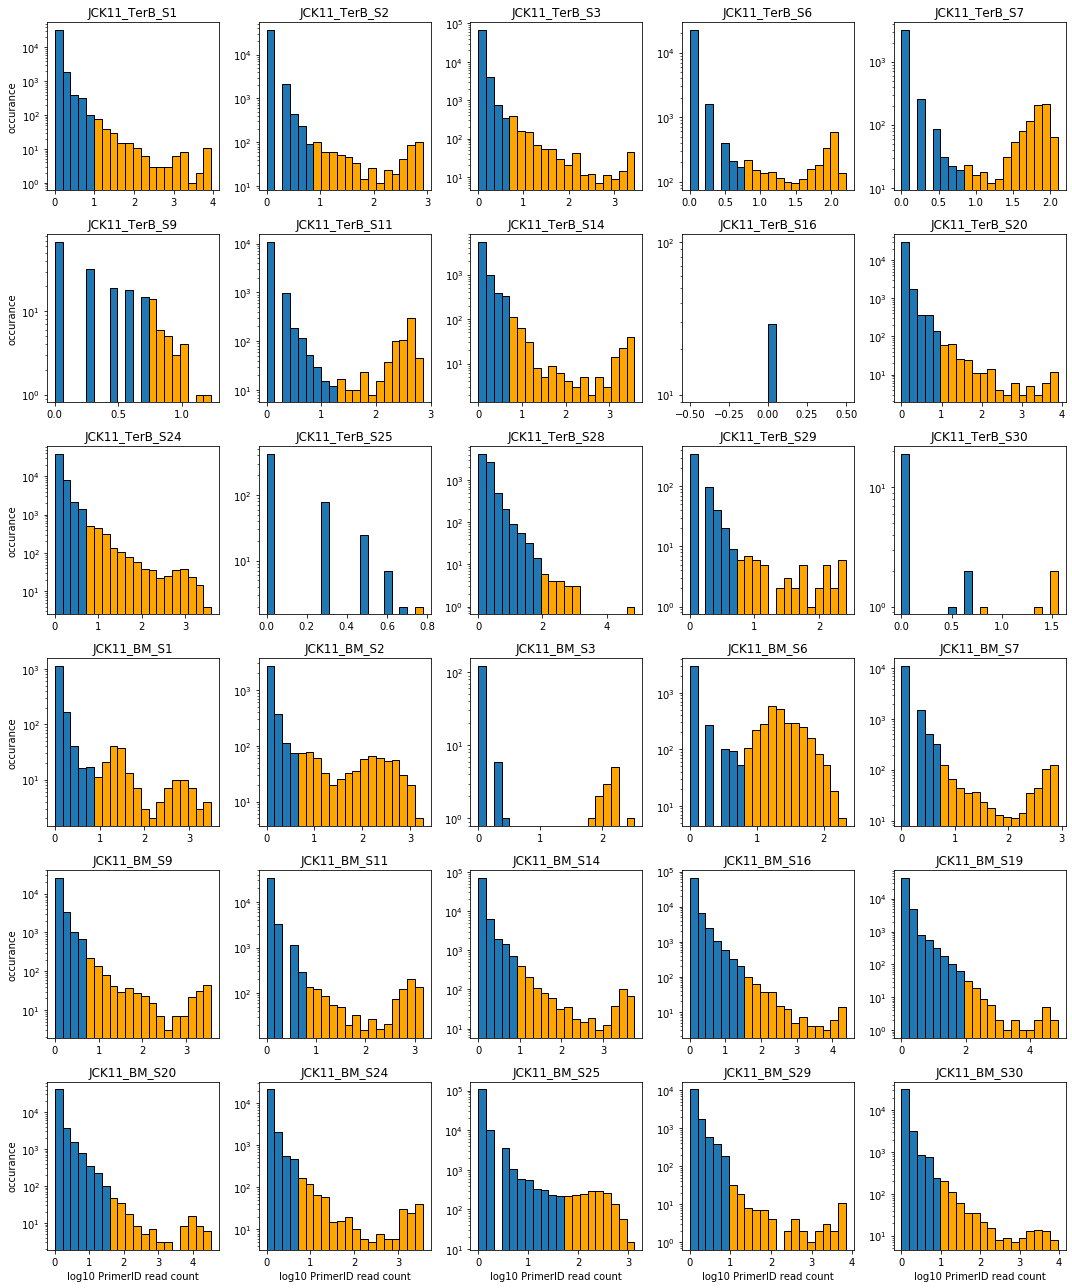

In [152]:
autolist = ['JCK11_TerB_S2','JCK11_TerB_S3','JCK11_TerB_S6','JCK11_TerB_S7', 'JCK11_TerB_S11','JCK11_BM_S2',
            'JCK11_BM_S6','JCK11_BM_S25']

plt.figure(figsize=(15,18))
ploti = 0
t6dict = {}

for sample in s6list:
    ploti += 1
    plt.subplot(6,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p6dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 26: plt.xlabel('log10 PrimerID read count')
    for i in range(3,19):
        if n[i+1] != 0 and n[i]/n[i+1] < 1 and n[i] >= 1:
            peaki = i
            break
    top1count = sorted(p6dict[sample].items(), key=lambda kv:-kv[1])[0][1]
    if sample in autolist:
        t6dict[sample] = (10**bins[peaki])
    elif top1count > 5000:
        t6dict[sample] = top1count/1000
    elif top1count >= 5:
        t6dict[sample] = 5
    else:
        t6dict[sample] = top1count
    for i in range(20):
        if bins[i] > np.log10(t6dict[sample]):
            patches[i].set_facecolor('orange')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch6.png',dpi=600)

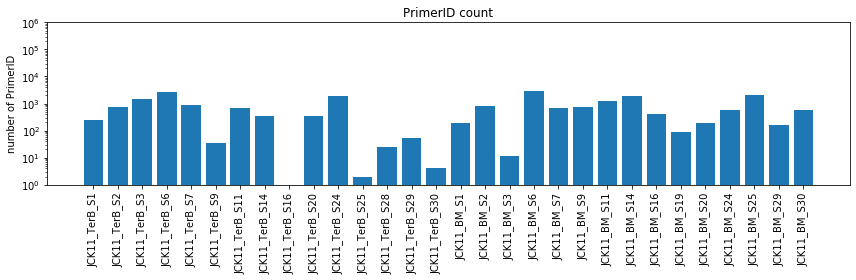

In [154]:
pidcountlist = []
for sample in s6list:
    countlist = list(p6dict[sample].values())
    pidcount = len([x for x in countlist if x > t6dict[sample]])
    pidcountlist.append(pidcount)
plt.figure(figsize=(12,4))
plt.bar(s6list,pidcountlist)
plt.yscale('log')
plt.title('PrimerID count')
plt.xticks(rotation=90)
plt.ylabel('number of PrimerID')
plt.ylim([1e0,1e6])
plt.tight_layout()
plt.savefig('PrimerID_count_batch6.png',dpi=600)

**Re-sequencing suggestion:**  
  
**JCK11_TerB_S9, JCK11_TermB_S16, JCK11_TerB_S25, JCK11_TermB_S30** have low sequencing depth, thus should be repeated with higher depth.    

**JCK11_TermB_S16,JCK11_TerB_S25,JCK11_TerB_S30,JCK11_BM_S3** have low number of cDNA molecules. So they should be repeated with more cDNA input.  

### batch7
JCK11 spleen

In [160]:
reffile = open('barcode/tag_batch7.txt')
tagdict = {}
for line in reffile:
    if '293T' in line: continue
    line = line.rstrip().rsplit('\t')
    tagdict[line[0]] = line[1]
reffile.close()
tagdict

{'CACAGT': 'JCK11_spleen_DNA_1',
 'CGCGTC': 'JCK11_spleen_DNA_2',
 'TATCGC': 'JCK11_spleen_DNA_3',
 'TGTGCT': 'JCK11_spleen_DNA_6',
 'TCATGA': 'JCK11_spleen_DNA_7',
 'CGTAGC': 'JCK11_spleen_DNA_8',
 'CGATGT': 'JCK11_spleen_DNA_14',
 'AGTCAG': 'JCK11_spleen_DNA_16',
 'GCTGAC': 'JCK11_spleen_DNA_19',
 'ACGCGT': 'JCK11_spleen_DNA_20',
 'GCACAG': 'JCK11_spleen_DNA_24',
 'ACGTAG': 'JCK11_spleen_DNA_25',
 'AGAGCG': 'JCK11_spleen_DNA_29',
 'ACGATA': 'JCK11_spleen_DNA_30'}

In [161]:
infiles = sorted(glob.glob('barcode/batch7/Undetermined_S0_*.txt'))
p7dict = {}
for tag in tagdict:
    p7dict[tagdict[tag]] = {}
for infile in infiles:
    inhandle = open(infile)
    for line in inhandle:
        line = line.rstrip().rsplit('\t')
        tag  = line[0]
        if tag not in tagdict: continue
        pid  = line[2]
        sample = tagdict[tag]
        if pid not in p7dict[sample]: p7dict[sample][pid] = 0
        p7dict[sample][pid] += 1
    inhandle.close()

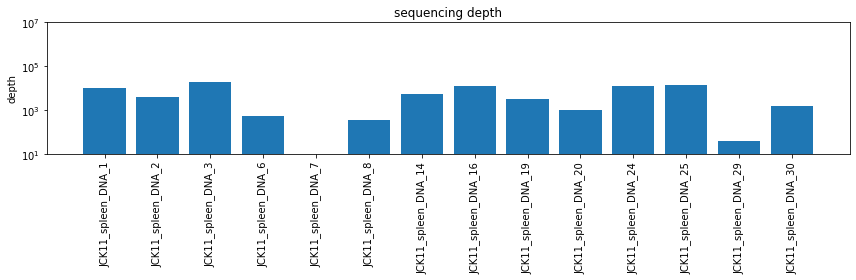

In [162]:
s7list = list(p7dict.keys())
depthlist = [sum(p7dict[x].values()) for x in s7list]
plt.figure(figsize=(12,4))
plt.bar(s7list,depthlist)
plt.yscale('log')
plt.title('sequencing depth')
plt.xticks(rotation=90)
plt.ylabel('depth')
plt.ylim([1e1,1e7])
plt.tight_layout()
plt.savefig('sequencing_depth_batch7.png',dpi=600)

missing sample JCK11_spleen_DNA_7

/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  import sys


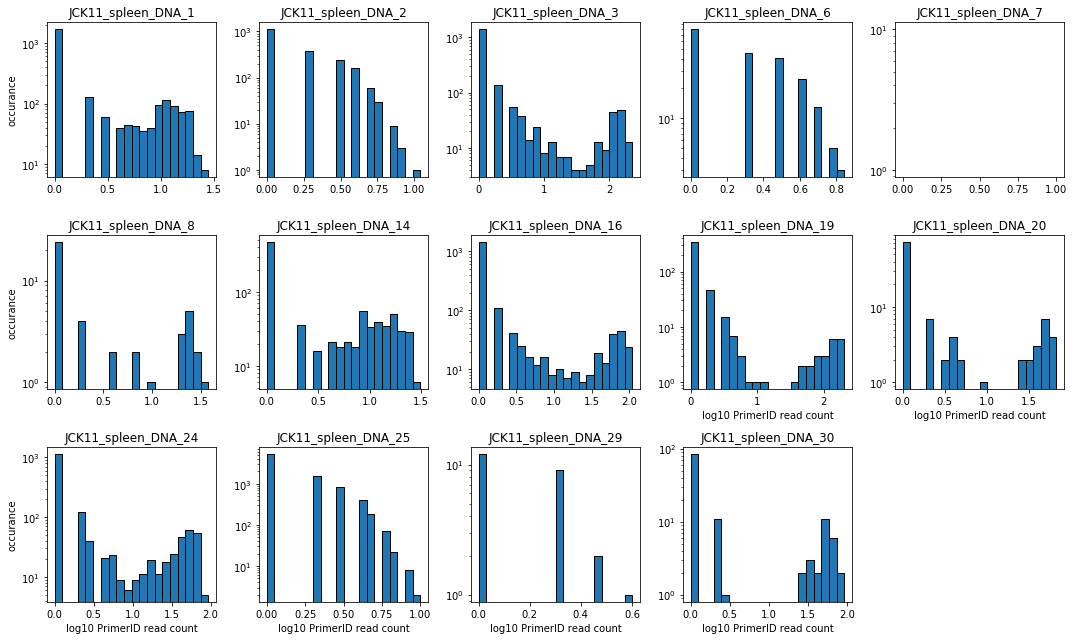

In [163]:
plt.figure(figsize=(15,9))
ploti = 0
for sample in s7list:
    ploti += 1
    plt.subplot(3,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p7dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 9: plt.xlabel('log10 PrimerID read count')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch7.png',dpi=600)

Sample 3, 16 are good. But let me look at S6, S29, etc.

In [166]:
sample = 'JCK11_spleen_DNA_6'
toplist = sorted(p7dict[sample].items(), key=lambda kv:-kv[1])
for i in range(40):
    print(toplist[i])

('CTGCAGAGTGGGT', 7)
('TGAACTGTCTTCT', 7)
('ACAAGGACGGGAT', 7)
('TTTATCGTTGTCT', 6)
('TGTGCTCTACGTT', 6)
('TTTGTTCGAGTCT', 6)
('GTTCTTTTGGCAT', 6)
('AGACGCCGTATAT', 6)
('TGGTTTGGGACTT', 5)
('ACTCATTGCCTAT', 5)
('AACTAGTACATGT', 5)
('GCCCTATCTACTT', 5)
('GAGGTGTGTGGAT', 5)
('GGAGCAGTTGGGT', 5)
('GACAGGGAACACT', 5)
('TCGAGCAGTCTGT', 5)
('GAAGTCTCTGTTT', 5)
('TGAAAGCTTGGGT', 5)
('TGCTATTTATCTT', 5)
('GTTTACGTAAATT', 5)
('TATGTTGGTTGAT', 5)
('CAGTTTTTCAGTT', 4)
('TGAGGTAGTACTT', 4)
('TTGATGAGCAGCT', 4)
('GGCGGAGGATGGT', 4)
('ATCAAGGAAGTGT', 4)
('CACCTAACTAGAT', 4)
('AGTTTCTCTCTTT', 4)
('TGGTCGCGGGGGT', 4)
('CATTTTTACAACT', 4)
('ATCAAGGCGCACT', 4)
('ATTCCATTGTTTT', 4)
('GGGTCGGCGCAGT', 4)
('CTTTAGTGCAGGT', 4)
('GGTCTTTACGTCT', 4)
('CTCGACGTCCAGT', 4)
('TTTACTCCCAGAT', 4)
('TTTGCGGATAGTT', 4)
('AAGATGATGTTAT', 4)
('CGGGTGGTACGAT', 4)


In [168]:
sample = 'JCK11_spleen_DNA_29'
toplist = sorted(p7dict[sample].items(), key=lambda kv:-kv[1])
for i in range(40):
    if i<len(toplist):
        print(toplist[i])

('CGGGTGTAGCATT', 4)
('AGAGGAGGGATAT', 3)
('TACGGTGGGGTAT', 3)
('GAGATGAATGTAT', 2)
('TGGTTCTAGCGAT', 2)
('TGTAGGTCGATGT', 2)
('TGTTATACGGTTT', 2)
('CCACCCGCTAATT', 2)
('AATTGCGGAAAAT', 2)
('GGTTGGTTCATTT', 2)
('CGTAGAGGCCATT', 2)
('TTTCTTTGGTGTT', 2)
('TGTGACTTGTTAT', 1)
('CCTTATTAATTCT', 1)
('ATGCGCGCGGGCT', 1)
('CTGGTGGGATCTT', 1)
('TAACGTGCAAGGT', 1)
('TCCTCCTTCGAGT', 1)
('TACGGTGGGGTCT', 1)
('ATTTTGCAACAAT', 1)
('TTGCCCTTAATAT', 1)
('CGTAGAGGCCCTT', 1)
('TTATGGTGTGGCT', 1)
('TACGGTACGTGGT', 1)


Though not read many times, each PrimerID is very uniqe for sample 6 and S29. They should be counted as real PrimerIDs.

/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  # This is added back by InteractiveShellApp.init_path()


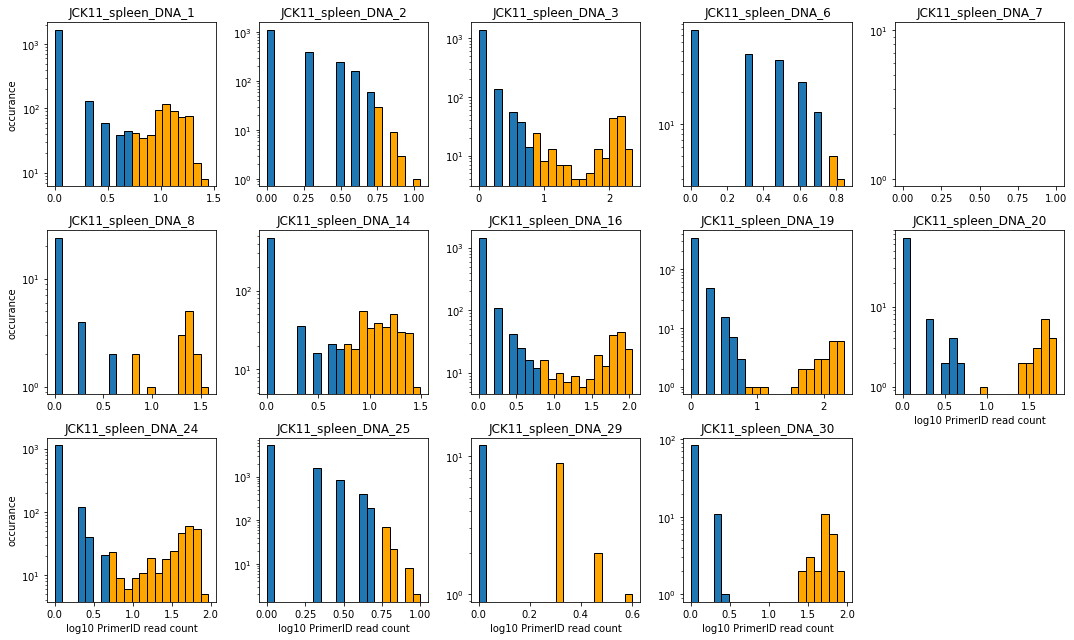

In [173]:
autolist = ['JCK11_spleen_DNA_3','JCK11_spleen_DNA_16','JCK11_spleen_DNA_24' ]

plt.figure(figsize=(15,9))
ploti = 0
t7dict = {}

for sample in s7list:
    ploti += 1
    plt.subplot(3,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p7dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 10: plt.xlabel('log10 PrimerID read count')
    for i in range(3,19):
        if n[i+1] != 0 and n[i]/n[i+1] < 1 and n[i] >= 1:
            peaki = i
            break
    if len(p7dict[sample]) >= 1:
        top1count = sorted(p7dict[sample].items(), key=lambda kv:-kv[1])[0][1]
    else:
        top1count = 1
    if sample in autolist:
        t7dict[sample] = (10**bins[peaki])
    elif top1count > 5000:
        t7dict[sample] = top1count/1000
    elif top1count >= 5:
        t7dict[sample] = 5
    else:
        t7dict[sample] = 1
    for i in range(20):
        if bins[i] > np.log10(t7dict[sample]):
            patches[i].set_facecolor('orange')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch7.png',dpi=600)

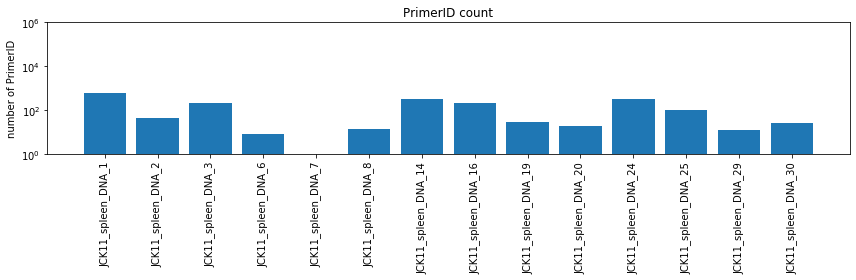

In [174]:
pidcountlist = []
for sample in s7list:
    countlist = list(p7dict[sample].values())
    pidcount = len([x for x in countlist if x > t7dict[sample]])
    pidcountlist.append(pidcount)
plt.figure(figsize=(12,4))
plt.bar(s7list,pidcountlist)
plt.yscale('log')
plt.title('PrimerID count')
plt.xticks(rotation=90)
plt.ylabel('number of PrimerID')
plt.ylim([1e0,1e6])
plt.tight_layout()
plt.savefig('PrimerID_count_batch7.png',dpi=600)

**Re-sequencing suggestion:**  
  
**JCK11_Spleen_DNA_2,6,7,25,29** should be sequenced with higer depth.  
8,19,20,30 could be sequenced with more cDNA input.

### batch8
JCK12 TermB and JCK11 Implant

In [180]:
reffile = open('barcode/tag_batch8.txt')
tagdict = {}
for line in reffile:
    if '293T' in line or 'CD4' in line: continue
    line = line.rstrip().rsplit('\t')
    tagdict[line[0]] = line[1]
reffile.close()
tagdict

{'CACAGT': 'JCK12_Term_Bleed_#1',
 'CGCGTC': 'JCK12_Term_Bleed_#5',
 'TATCGC': 'JCK12_Term_Bleed_#9',
 'TGTGCT': 'JCK12_Term_Bleed_#11',
 'TCATGA': 'JCK12_Term_Bleed_#12',
 'CGTAGC': 'JCK12_Term_Bleed_#18',
 'CGATGT': 'JCK12_Term_Bleed_#21',
 'AGTCAG': 'JCK12_Term_Bleed_#23',
 'GCACAG': 'JCK11_Implant_#2',
 'ACGTAG': 'JCK11_Implant_#11'}

In [181]:
infiles = sorted(glob.glob('barcode/batch8/Undetermined_S0_*.txt'))
p8dict = {}
for tag in tagdict:
    p8dict[tagdict[tag]] = {}
for infile in infiles:
    inhandle = open(infile)
    for line in inhandle:
        line = line.rstrip().rsplit('\t')
        tag  = line[0]
        if tag not in tagdict: continue
        pid  = line[2]
        sample = tagdict[tag]
        if pid not in p8dict[sample]: p8dict[sample][pid] = 0
        p8dict[sample][pid] += 1
    inhandle.close()

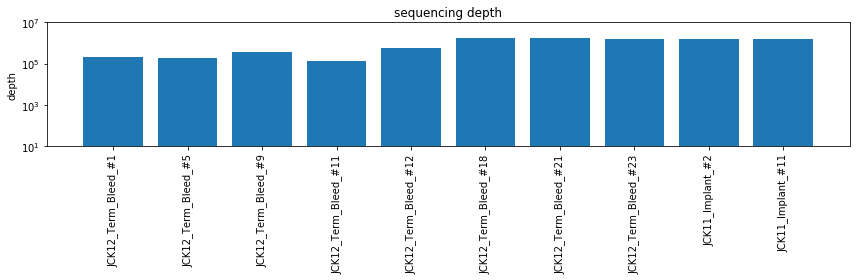

In [182]:
s8list = list(p8dict.keys())
depthlist = [sum(p8dict[x].values()) for x in s8list]
plt.figure(figsize=(12,4))
plt.bar(s8list,depthlist)
plt.yscale('log')
plt.title('sequencing depth')
plt.xticks(rotation=90)
plt.ylabel('depth')
plt.ylim([1e1,1e7])
plt.tight_layout()
plt.savefig('sequencing_depth_batch8.png',dpi=600)

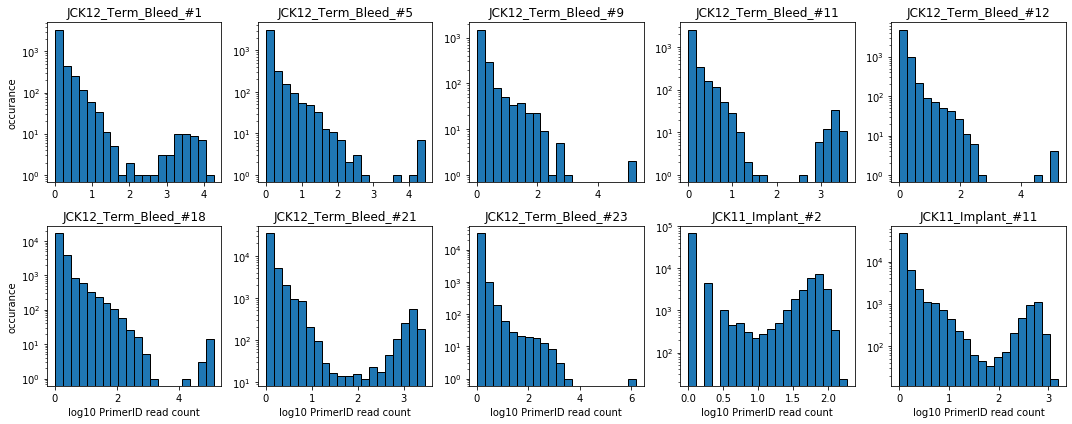

In [184]:
plt.figure(figsize=(15,6))
ploti = 0
for sample in s8list:
    ploti += 1
    plt.subplot(2,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p8dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 6: plt.xlabel('log10 PrimerID read count')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch8.png',dpi=600)

Over-amplification is still a problem in this batch. The distribution  is not ideal.

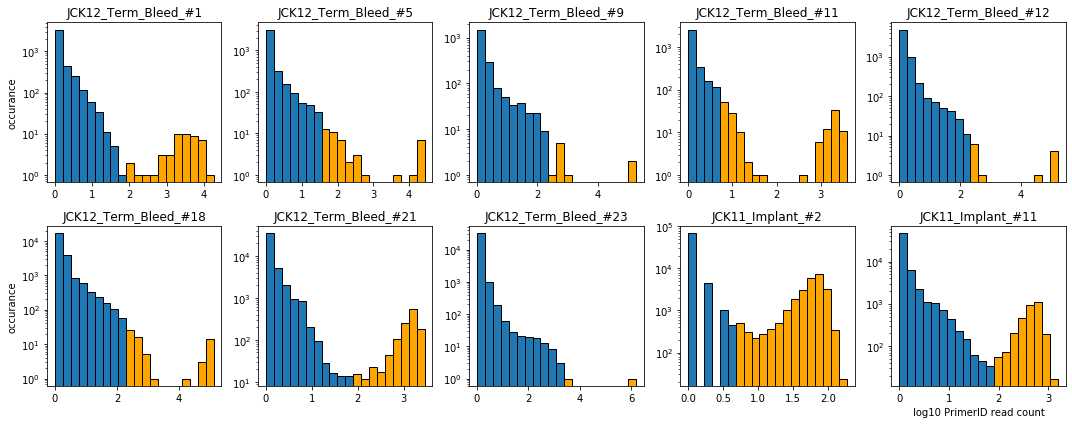

In [185]:
autolist = ['JCK12_Term_Bleed_#1','JCK12_Term_Bleed_#21','JCK11_Implant_#2','JCK11_Implant_#11' ]

plt.figure(figsize=(15,6))
ploti = 0
t8dict = {}

for sample in s8list:
    ploti += 1
    plt.subplot(2,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p8dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 10: plt.xlabel('log10 PrimerID read count')
    for i in range(3,19):
        if n[i+1] != 0 and n[i]/n[i+1] < 1 and n[i] >= 1:
            peaki = i
            break
    if len(p8dict[sample]) >= 1:
        top1count = sorted(p8dict[sample].items(), key=lambda kv:-kv[1])[0][1]
    else:
        top1count = 1
    if sample in autolist:
        t8dict[sample] = (10**bins[peaki])
    elif top1count > 5000:
        t8dict[sample] = top1count/1000
    elif top1count >= 5:
        t8dict[sample] = 5
    else:
        t8dict[sample] = 1
    for i in range(20):
        if bins[i] > np.log10(t8dict[sample]):
            patches[i].set_facecolor('orange')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch8.png',dpi=600)

In [186]:
sample = 'JCK12_Term_Bleed_#23'
toplist = sorted(p8dict[sample].items(), key=lambda kv:-kv[1])
for i in range(40):
    if i<len(toplist):
        print(toplist[i])

('TTTTTAAGCCGCT', 1487841)
('TTTTAAAGCCGCT', 3767)
('TTTTAAGCCGCT', 2253)
('GACCTCTCAACGT', 2232)
('AAACGATACCATT', 1450)
('TTTTTAAGTCGCT', 954)
('TTTTCAAGCCGCT', 924)
('TTTTTAATCCGCT', 833)
('TTTTTAAGCAGCT', 817)
('ATTTTAAGCCGCT', 809)
('TTTATAAGCCGCT', 762)
('TTTTTGAGCCGCT', 607)
('TTTTTAAGCCACT', 607)
('TTGTTAAGCCGCT', 569)
('TTATTAAGCCGCT', 559)
('TTTGTAAGCCGCT', 533)
('ATGATGGACCGCT', 496)
('TTTTTAAGCCGAT', 486)
('TTTTTAAGACGCT', 472)
('TTTTTAAGCCGCG', 468)
('TTTCTAAGCCGCT', 457)
('TATTTAAGCCGCT', 414)
('TTTTTAAGCCGCA', 349)
('AATTCGCAGGTAT', 325)
('TTCTTAAGCCGCT', 310)
('TTTTTAAGCTGCT', 303)
('TTTTTAAGCCGCC', 285)
('TTTTTAGGCCGCT', 247)
('TCTTTAAGCCGCT', 216)
('TTTTTTAGCCGCT', 210)
('CTTTTAAGCCGCT', 210)
('CTTTTATTGACAT', 209)
('TTTTTAAGCCTCT', 193)
('GCTAGACAGGCGT', 192)
('TTTTGTCTCCAGT', 185)
('TGTAGGTGAACTT', 177)
('TCAGTAGATAAAT', 176)
('TACGACTGTTTTT', 165)
('TTGTTAATTGATT', 165)
('TTTTTAAACCGCT', 154)


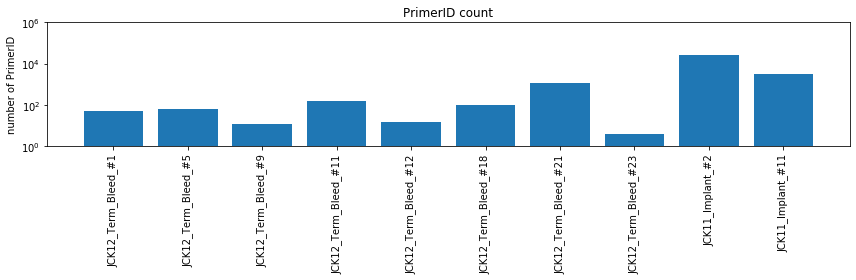

In [187]:
pidcountlist = []
for sample in s8list:
    countlist = list(p8dict[sample].values())
    pidcount = len([x for x in countlist if x > t8dict[sample]])
    pidcountlist.append(pidcount)
plt.figure(figsize=(12,4))
plt.bar(s8list,pidcountlist)
plt.yscale('log')
plt.title('PrimerID count')
plt.xticks(rotation=90)
plt.ylabel('number of PrimerID')
plt.ylim([1e0,1e6])
plt.tight_layout()
plt.savefig('PrimerID_count_batch8.png',dpi=600)

**Resequencing suggestions:**  
Though the sequencing depth for all samples are sufficient, some samples are still hampered by insufficient amount of cDNA input or significant PCR scewing.   
I would suggest to re-do **JCK12_Term_Bleed_#23, JCK12_Term_Bleed_#9, JCK12_Term_Bleed_#12** with more cDNA input.

### batch9
JCK12, Bone Marrow, Spleen, Implant, Terminal Bleed.

In [197]:
reffile = open('barcode/tag_batch9.txt')
tagdict = {}
header = reffile.readline()
for line in reffile:
    if '293T' in line or 'CD4' in line: continue
    line = line.rstrip().rsplit('\t')
    name = line[2].replace(' ','_').replace('/','_') 
    name = name.rsplit('_')
    tagdict[line[0]+'_'+line[1]] = name[0]+'_'+name[1]+'_'+name[-1]
reffile.close()
tagdict

{'pool1_CACAGT': 'JCK12_Bone_#9',
 'pool1_CGCGTC': 'JCK12_Bone_#20',
 'pool1_TATCGC': 'JCK12_Bone_#23',
 'pool1_TGTGCT': 'JCK12_Bone_#31',
 'pool1_TCATGA': 'JCK12_Bone_#38',
 'pool1_CGTAGC': 'JCK12_Terminal_#9',
 'pool1_CGATGT': 'JCK12_Terminal_#12',
 'pool1_AGTCAG': 'JCK12_Terminal_#20',
 'pool1_': 'JCK12_Terminal_#31',
 'pool2_CACAGT': 'JCK12_Terminal_#38',
 'pool2_CGCGTC': 'JCK12_Bone_#1',
 'pool2_TATCGC': 'JCK12_Bone_#5',
 'pool2_TGTGCT': 'JCK12_Bone_#11',
 'pool2_TCATGA': 'JCK12_Bone_#12',
 'pool2_CGTAGC': 'JCK12_Bone_#18',
 'pool2_CGATGT': 'JCK12_Bone_#21',
 'pool2_AGTCAG': 'JCK12_Spleen_#1',
 'pool2_': 'JCK12_Spleen_#5',
 'pool3_CACAGT': 'JCK12_Spleen_#11',
 'pool3_CGCGTC': 'JCK12_Spleen_#18',
 'pool3_TATCGC': 'JCK12_Spleen_#21',
 'pool3_TGTGCT': 'JCK12_Spleen_#22',
 'pool3_TCATGA': 'JCK12_Spleen_#23',
 'pool3_CGTAGC': 'JCK12_Spleen_#31',
 'pool3_CGATGT': 'JCK12_Spleen_#38',
 'pool3_AGTCAG': 'JCK12_Implant_#1',
 'pool3_': 'JCK12_Implant_#5',
 'pool4_CACAGT': 'JCK12_Implant_#9',


In [198]:
infiles = sorted(glob.glob('barcode/batch9/JCK_pool*.txt'))
p9dict = {}
for tag in tagdict:
    p9dict[tagdict[tag]] = {}
for infile in infiles:
    inhandle = open(infile)
    pool = infile.rsplit('JCK_')[-1].rsplit('_S')[0]
    for line in inhandle:
        line = line.rstrip().rsplit('\t')
        tag  = pool+'_'+line[0]
        if tag not in tagdict: continue
        pid  = line[2]
        sample = tagdict[tag]
        if pid not in p9dict[sample]: p9dict[sample][pid] = 0
        p9dict[sample][pid] += 1
    inhandle.close()

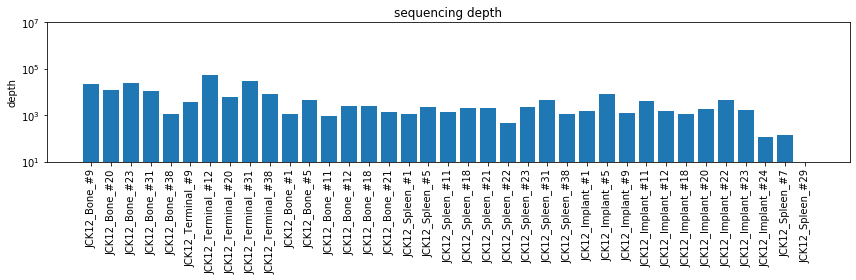

In [199]:
s9list = list(p9dict.keys())
depthlist = [sum(p9dict[x].values()) for x in s9list]
plt.figure(figsize=(12,4))
plt.bar(s9list,depthlist)
plt.yscale('log')
plt.title('sequencing depth')
plt.xticks(rotation=90)
plt.ylabel('depth')
plt.ylim([1e1,1e7])
plt.tight_layout()
plt.savefig('sequencing_depth_batch9.png',dpi=600)

JCK12_Spleen_29 has no read.

/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  import sys


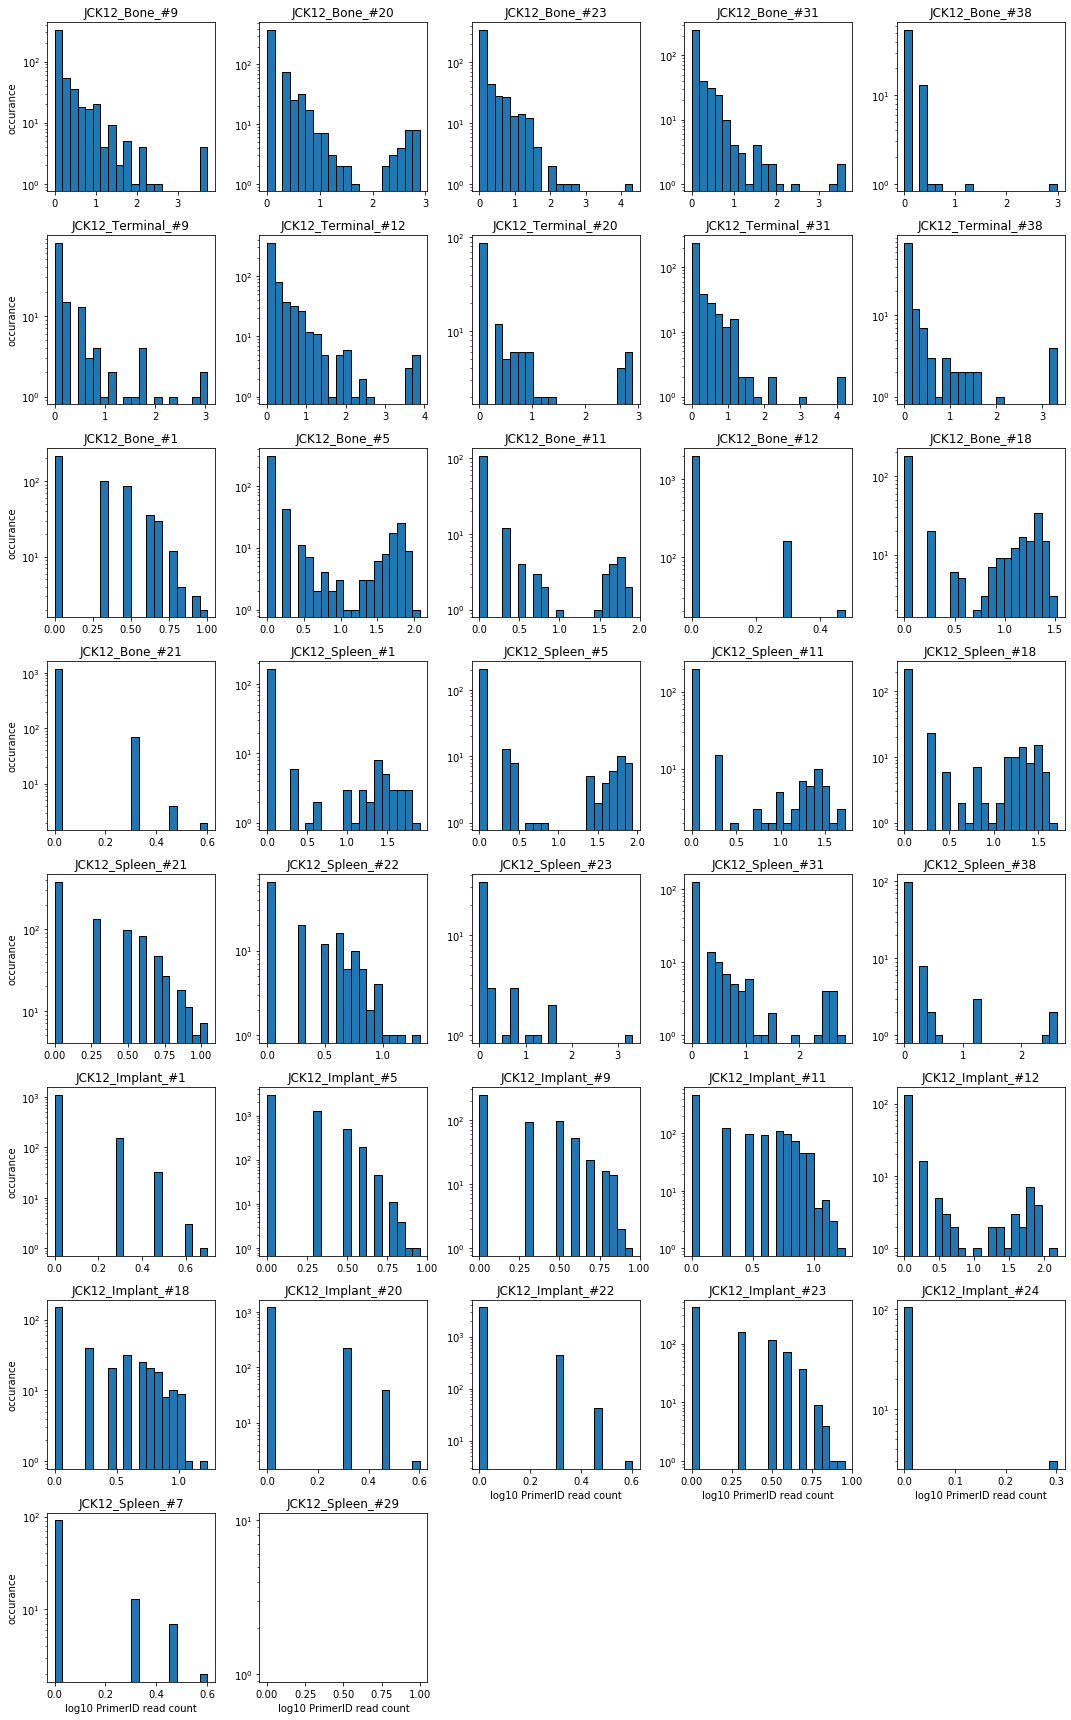

In [200]:
plt.figure(figsize=(15,24))
ploti = 0
for sample in s9list:
    ploti += 1
    plt.subplot(8,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p9dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 33: plt.xlabel('log10 PrimerID read count')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch9.png',dpi=600)

Bone marrow samples have rather typical bimodal distribution. But Spleen and Implant samples should be sequenced more. I think samples with lower than 1000 reads should be re-sequenced.  
Though not sequenced very deep, some PrimerIDs still have more than a few thousands reads.

In [201]:
print('low depth samples:')
for sample in s9list:
    if sum(p9dict[sample].values()) < 1000:
        print(sample)

low depth samples:
JCK12_Bone_#11
JCK12_Spleen_#22
JCK12_Implant_#24
JCK12_Spleen_#7
JCK12_Spleen_#29


/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  # Remove the CWD from sys.path while we load stuff.


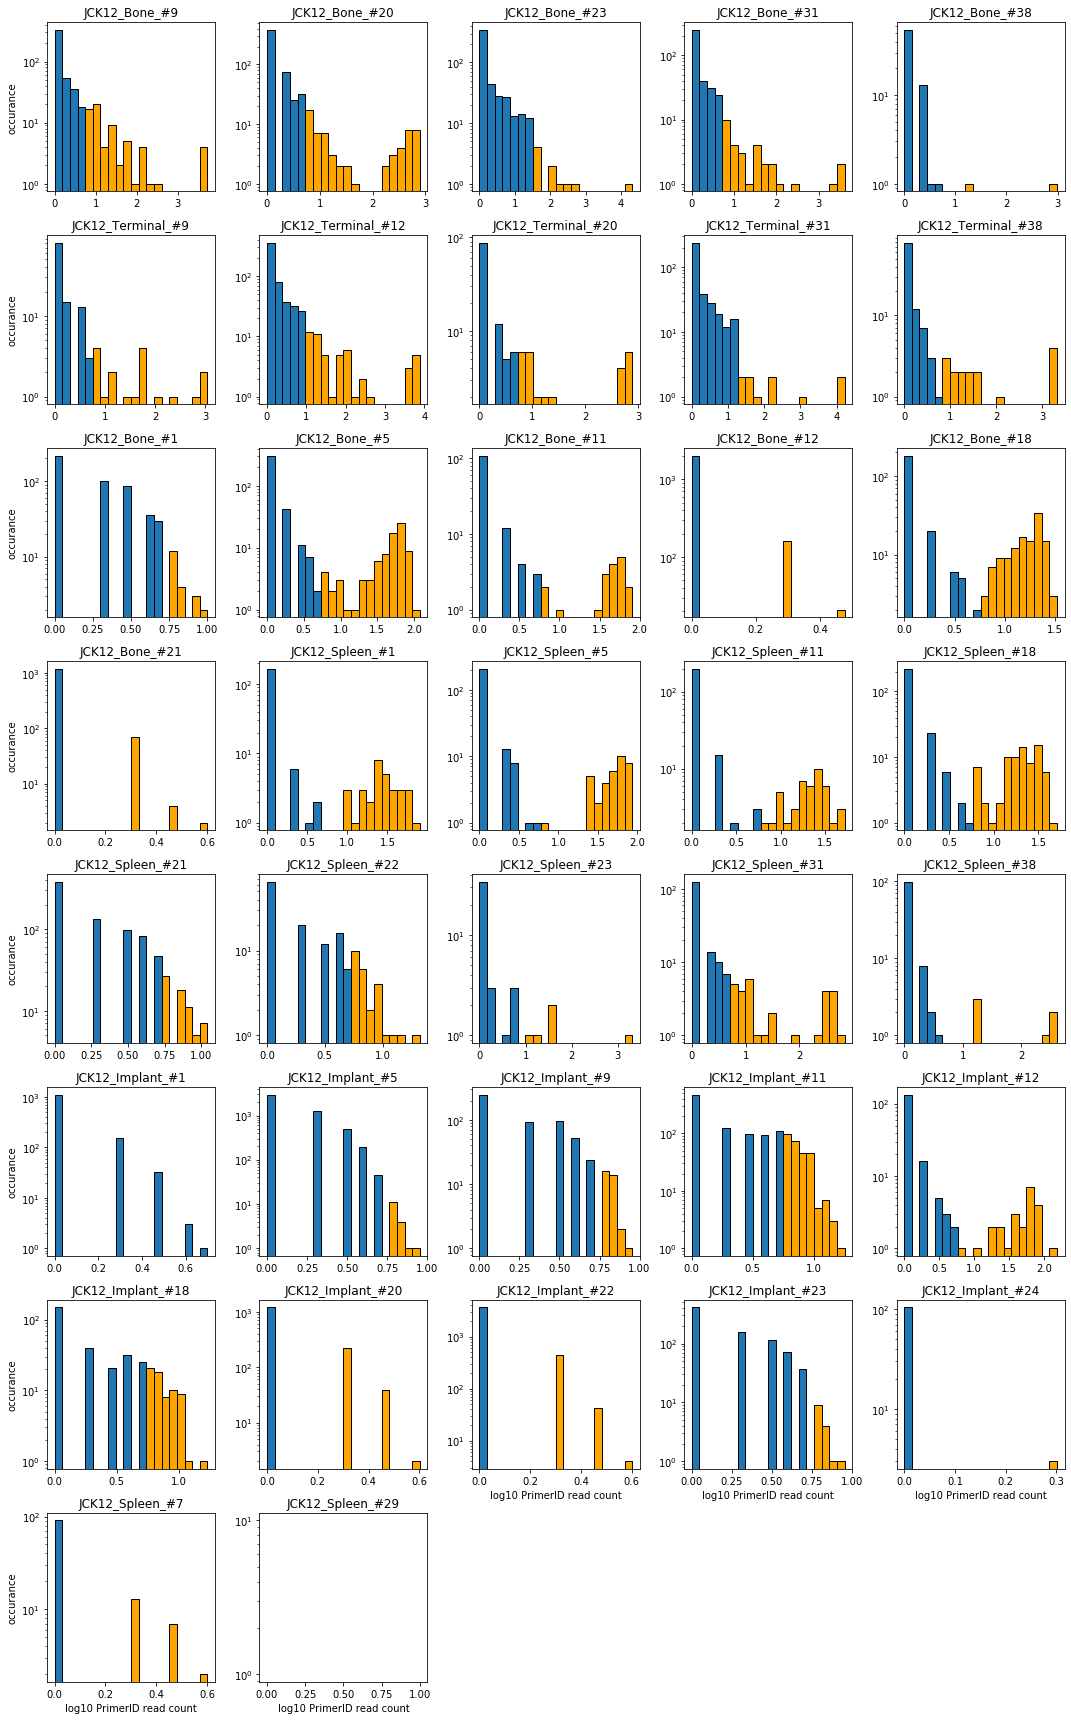

In [202]:
plt.figure(figsize=(15,24))
ploti = 0
t9dict = {}
autolist = ['JCK12_Bone_#11']

for sample in s9list:
    ploti += 1
    plt.subplot(8,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p9dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 33: plt.xlabel('log10 PrimerID read count')
    for i in range(3,19):
        if n[i+1] != 0 and n[i]/n[i+1] < 1 and n[i] >= 1:
            peaki = i
            break
    if len(p9dict[sample]) >= 1:
        top1count = sorted(p9dict[sample].items(), key=lambda kv:-kv[1])[0][1]
    else:
        top1count = 1
    if sample in autolist:
        t9dict[sample] = (10**bins[peaki])
    elif top1count > 5000:
        t9dict[sample] = top1count/1000
    elif top1count >= 5:
        t9dict[sample] = 5
    else:
        t9dict[sample] = 1
    for i in range(20):
        if bins[i] > np.log10(t9dict[sample]):
            patches[i].set_facecolor('orange')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch9.png',dpi=600)

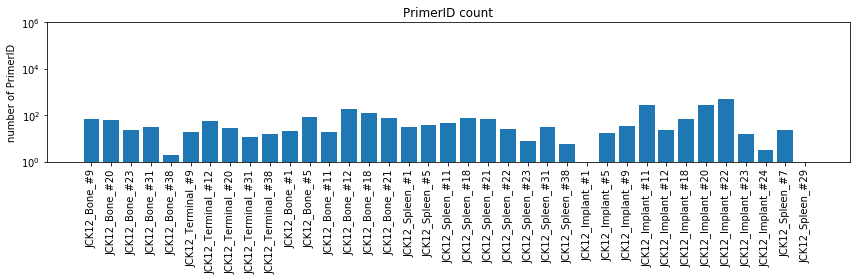

In [203]:
pidcountlist = []
for sample in s9list:
    countlist = list(p9dict[sample].values())
    pidcount = len([x for x in countlist if x > t9dict[sample]])
    pidcountlist.append(pidcount)
plt.figure(figsize=(12,4))
plt.bar(s9list,pidcountlist)
plt.yscale('log')
plt.title('PrimerID count')
plt.xticks(rotation=90)
plt.ylabel('number of PrimerID')
plt.ylim([1e0,1e6])
plt.tight_layout()
plt.savefig('PrimerID_count_batch9.png',dpi=600)

In [204]:
for sample in s9list:
    countlist = list(p9dict[sample].values())
    pidcount = len([x for x in countlist if x > t9dict[sample]])
    if pidcount < 50: print(sample)

JCK12_Bone_#23
JCK12_Bone_#31
JCK12_Bone_#38
JCK12_Terminal_#9
JCK12_Terminal_#20
JCK12_Terminal_#31
JCK12_Terminal_#38
JCK12_Bone_#1
JCK12_Bone_#11
JCK12_Spleen_#1
JCK12_Spleen_#5
JCK12_Spleen_#11
JCK12_Spleen_#22
JCK12_Spleen_#23
JCK12_Spleen_#31
JCK12_Spleen_#38
JCK12_Implant_#1
JCK12_Implant_#5
JCK12_Implant_#9
JCK12_Implant_#12
JCK12_Implant_#23
JCK12_Implant_#24
JCK12_Spleen_#7
JCK12_Spleen_#29


**Re-sequencing suggestions:**  
Following samples should be sequenced with more input:  
**JCK12_Bone_#23,
JCK12_Bone_#31,
JCK12_Bone_#38,
JCK12_Terminal_#9,
JCK12_Terminal_#20,
JCK12_Terminal_#31,
JCK12_Terminal_#38,
JCK12_Bone_#1,
JCK12_Bone_#11,
JCK12_Spleen_#1,
JCK12_Spleen_#5,
JCK12_Spleen_#11,
JCK12_Spleen_#22,
JCK12_Spleen_#23,
JCK12_Spleen_#31,
JCK12_Spleen_#38,
JCK12_Implant_#1,
JCK12_Implant_#5,
JCK12_Implant_#9,
JCK12_Implant_#12,
JCK12_Implant_#23,
JCK12_Implant_#24,
JCK12_Spleen_#7,
JCK12_Spleen_#29**  
Following samples should be sequenced with more depth:   
**JCK12_Bone_#11,
JCK12_Spleen_#22,
JCK12_Implant_#24,
JCK12_Spleen_#7,
JCK12_Spleen_#29**

### batch10

In [205]:
reffile = open('barcode/tag_batch10.txt')
tagdict = {}
for line in reffile:
    if '293T' in line or 'CD4' in line: continue
    line = line.rstrip().rsplit('\t')
    tagdict[line[0]] = line[1]
reffile.close()
tagdict

{'CACAGT': 'JCK12_spleen_S12',
 'CGCGTC': 'JCK12_spleen_S20',
 'TATCGC': 'JCK12_TermiB_S1',
 'TGTGCT': 'JCK12_TermiB_S5',
 'TCATGA': 'JCK12_TermiB_S9',
 'CGTAGC': 'JCK12_TermiB_S11',
 'CGATGT': 'JCK12_TermiB_S12',
 'AGTCAG': 'JCK12_TermiB_S18',
 'GCTGAC': 'JCK12_TermiB_S20',
 'ACGCGT': 'JCK12_TermiB_S21',
 'GCACAG': 'JCK12_TermiB_S23',
 'ACGTAG': 'JCK12_TermiB_S31',
 'AGAGCG': 'JCK12_TermiB_S38',
 'ACGATA': 'JCK12_BoneMr_S1',
 'CTGACG': 'JCK12_BoneMr_S5',
 'TCGAGC': 'JCK12_BoneMr_S9',
 'GAGCTA': 'JCK12_BoneMr_S11',
 'TATGAG': 'JCK12_BoneMr_S12',
 'TAGATG': 'JCK12_BoneMr_S18',
 'ATACAT': 'JCK12_BoneMr_S20',
 'GTCGTA': 'JCK12_BoneMr_S21',
 'ATATCA': 'JCK12_BoneMr_S23',
 'GTGTGC': 'JCK12_BoneMr_S31',
 'CATGTA': 'JCK12_BoneMr_S38'}

In [207]:
infiles = sorted(glob.glob('barcode/batch10/Undetermined_S0_*.txt'))
p10dict = {}
for tag in tagdict:
    p10dict[tagdict[tag]] = {}
for infile in infiles:
    inhandle = open(infile)
    for line in inhandle:
        line = line.rstrip().rsplit('\t')
        tag  = line[0]
        if tag not in tagdict: continue
        pid  = line[2]
        sample = tagdict[tag]
        if pid not in p10dict[sample]: p10dict[sample][pid] = 0
        p10dict[sample][pid] += 1
    inhandle.close()

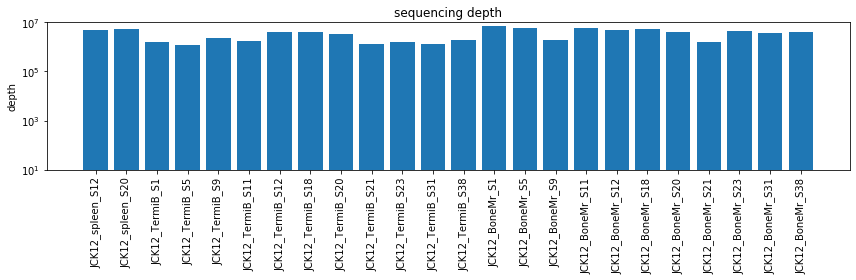

In [208]:
s10list = list(p10dict.keys())
depthlist = [sum(p10dict[x].values()) for x in s10list]
plt.figure(figsize=(12,4))
plt.bar(s10list,depthlist)
plt.yscale('log')
plt.title('sequencing depth')
plt.xticks(rotation=90)
plt.ylabel('depth')
plt.ylim([1e1,1e7])
plt.tight_layout()
plt.savefig('sequencing_depth_batch10.png',dpi=600)

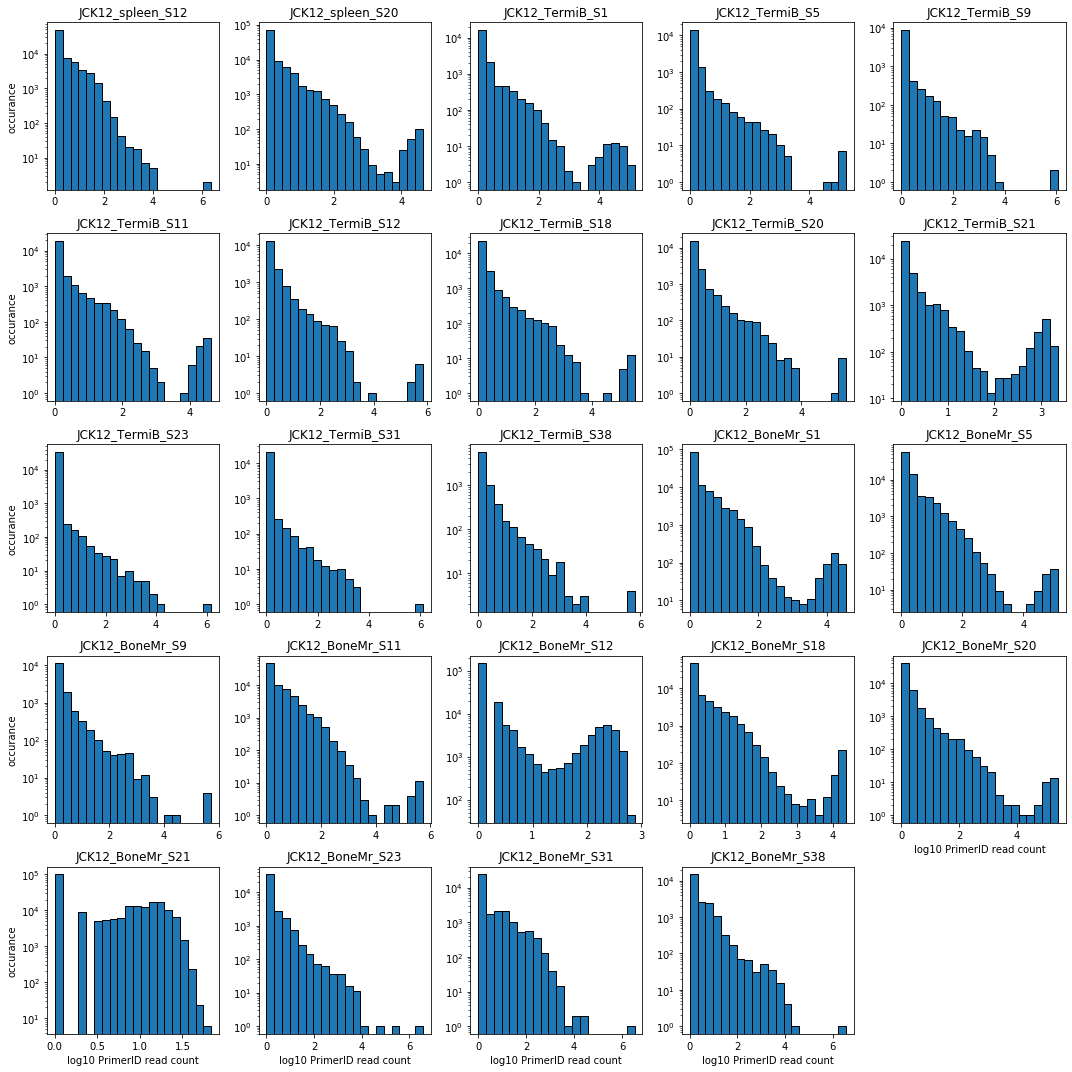

In [210]:
plt.figure(figsize=(15,15))
ploti = 0
for sample in s10list:
    ploti += 1
    plt.subplot(5,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p10dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 20: plt.xlabel('log10 PrimerID read count')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch10.png',dpi=600)

Only JCK12_BM_S12 has a clear separation. The rest I cannot set simple threshold. Some samples, like JCK12_BM_S21 definately have very high input count. But some samples, like JCK12_TermB_S31 will not have much PrimerIDs. Let's see.

In [212]:
sample = 'JCK12_TermiB_S31'
toplist = sorted(p10dict[sample].items(), key=lambda kv:-kv[1])
for i in range(40):
    if i<len(toplist):
        print(toplist[i])

('AAGTATCCGCGAT', 1309171)
('AAGTAACCGCGAT', 2855)
('AAGTCTCCGCGAT', 2409)
('TAGTATCCGCGAT', 2319)
('AAGTATCCTCGAT', 2190)
('AAGTATCAGCGAT', 1572)
('AAGTATACGCGAT', 1341)
('AAGAATCCGCGAT', 1242)
('AATTATCCGCGAT', 1164)
('AAGTATCCGCGCT', 1047)
('GAGTATCCGCGAT', 1019)
('ACCATGACCGATT', 901)
('AAGTATCCGCGTT', 866)
('AAGTATCCGCGAA', 851)
('ACGTATCCGCGAT', 766)
('AAGTATCCGAGAT', 763)
('TCAGTCATAGGTT', 736)
('AAGTATCCGCGAG', 604)
('ATGTATCCGCGAT', 567)
('AAGTATCCGCGGT', 519)
('AAGTATCTGCGAT', 466)
('TTACCGTATGTTT', 349)
('AAGTATCCGTGAT', 346)
('CAGTATCCGCGAT', 326)
('AAGTATCCGCTAT', 325)
('AGGTATCCGCGAT', 316)
('AAGTATCCACGAT', 311)
('AAGTAGCCGCGAT', 297)
('TGGTCCAGTGGCT', 262)
('AAGTATTCGCGAT', 258)
('TGTGCCACCGTAT', 222)
('ACATCCGCGTTTT', 217)
('AAGTATCCGCAAT', 217)
('TATCGATAGTAGT', 202)
('AAGTATCCCCGAT', 199)
('AAGTTTCCGCGAT', 166)
('ACCACAAATGTAT', 160)
('AAGTATCCGCCAT', 145)
('AAGGATCCGCGAT', 143)
('AAGTGTCCGCGAT', 141)


It seems only one molecule was sequenced.

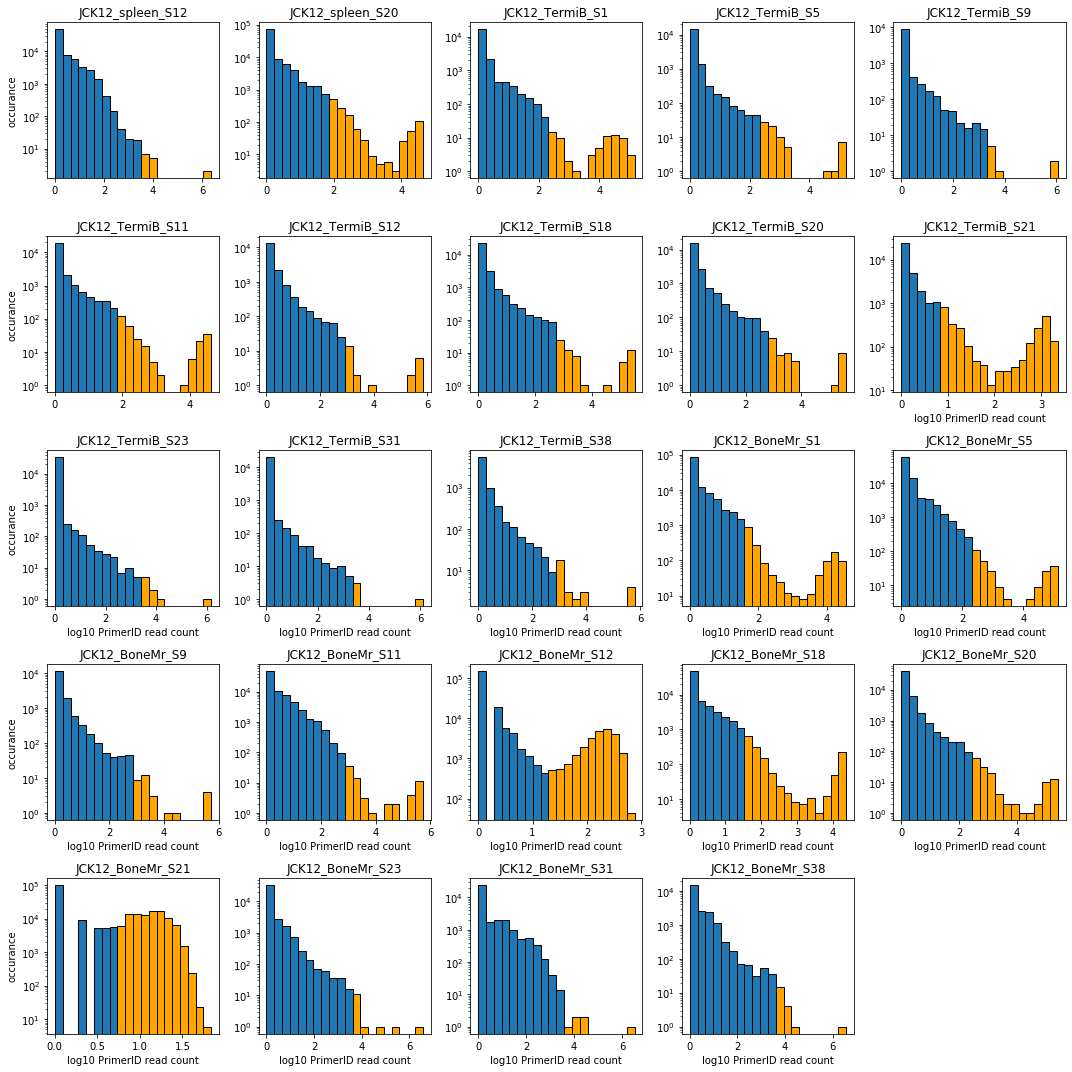

In [214]:
autolist = ['JCK12_BoneMr_S12']

plt.figure(figsize=(15,15))
ploti = 0
t10dict = {}

for sample in s10list:
    ploti += 1
    plt.subplot(5,5,ploti)
    n, bins, patches = plt.hist(np.log10(list(p10dict[sample].values())),edgecolor='black',bins=20)
    plt.yscale('log')
    plt.title(sample)
    if ploti % 5 == 1: plt.ylabel('occurance')
    if ploti >= 10: plt.xlabel('log10 PrimerID read count')
    for i in range(3,19):
        if n[i+1] != 0 and n[i]/n[i+1] < 1 and n[i] >= 1:
            peaki = i
            break
    if len(p10dict[sample]) >= 1:
        top1count = sorted(p10dict[sample].items(), key=lambda kv:-kv[1])[0][1]
    else:
        top1count = 1
    if sample in autolist:
        t10dict[sample] = (10**bins[peaki])
    elif top1count > 5000:
        t10dict[sample] = top1count/1000
    elif top1count >= 5:
        t10dict[sample] = 5
    else:
        t10dict[sample] = 1
    for i in range(20):
        if bins[i] > np.log10(t10dict[sample]):
            patches[i].set_facecolor('orange')
plt.tight_layout()
plt.savefig('PID_count_distribution_batch10.png',dpi=600)

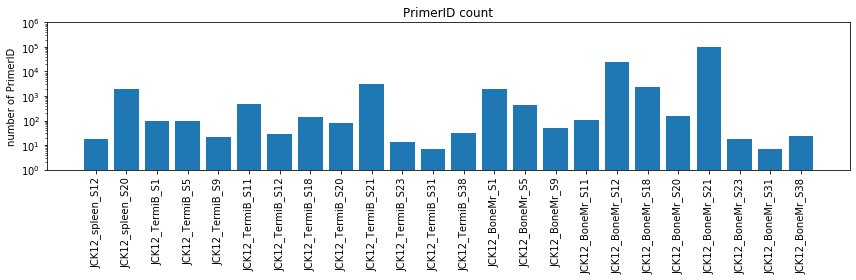

In [215]:
pidcountlist = []
for sample in s10list:
    countlist = list(p10dict[sample].values())
    pidcount = len([x for x in countlist if x > t10dict[sample]])
    pidcountlist.append(pidcount)
plt.figure(figsize=(12,4))
plt.bar(s10list,pidcountlist)
plt.yscale('log')
plt.title('PrimerID count')
plt.xticks(rotation=90)
plt.ylabel('number of PrimerID')
plt.ylim([1e0,1e6])
plt.tight_layout()
plt.savefig('PrimerID_count_batch10.png',dpi=600)

In [216]:
for sample in s10list:
    countlist = list(p10dict[sample].values())
    pidcount = len([x for x in countlist if x > t10dict[sample]])
    if pidcount < 50: print(sample)

JCK12_spleen_S12
JCK12_TermiB_S9
JCK12_TermiB_S12
JCK12_TermiB_S23
JCK12_TermiB_S31
JCK12_TermiB_S38
JCK12_BoneMr_S23
JCK12_BoneMr_S31
JCK12_BoneMr_S38


**Resequencing suggestions:**  
These samples could be sequenced with more cDNA input.    
JCK12_spleen_S12,
JCK12_TermiB_S9,
JCK12_TermiB_S12,
JCK12_TermiB_S23,
JCK12_TermiB_S31,
JCK12_TermiB_S38,
JCK12_BoneMr_S23,
JCK12_BoneMr_S31,
JCK12_BoneMr_S38.  
Not the top priority.

### 2. Call barcode using confident PrimerIDs

In [14]:
def most_common(List): 
    return max(set(List), key = List.count) 

In [33]:
#It seems clustering similar barcodes is still necessary.
!cd-hit

		====== CD-HIT version 4.8.1 (built on Mar  1 2019) ======

Usage: cd-hit [Options] 

Options

   -i	input filename in fasta format, required, can be in .gz format
   -o	output filename, required
   -c	sequence identity threshold, default 0.9
 	this is the default cd-hit's "global sequence identity" calculated as:
 	number of identical amino acids or bases in alignment
 	divided by the full length of the shorter sequence
   -G	use global sequence identity, default 1
 	if set to 0, then use local sequence identity, calculated as :
 	number of identical amino acids or bases in alignment
 	divided by the length of the alignment
 	NOTE!!! don't use -G 0 unless you use alignment coverage controls
 	see options -aL, -AL, -aS, -AS
   -b	band_width of alignment, default 20
   -M	memory limit (in MB) for the program, default 800; 0 for unlimitted;
   -T	number of threads, default 1; with 0, all CPUs will be used
   -n	word_length, default 5, see user's guide for choosing it
   -l	length of thr

### 3. Diversity and variation


### 4. write files